[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/Neuroscience/pose_estimation.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/Neuroscience/pose_estimation.ipynb)

# Animal Pose Estimation
**By Neuromatch Academy**

__Content creators:__ Kristin Branson

__Produtction editors:__ Gagana B, Spiros Chavlis

---
# Objectives

Train a deep network that can predict the locations of parts of animals. This Colab Notebook has all the code necessary to train a UNet network to predict the positions of 17 parts on a fruit fly.

**Project ideas:**

1. (easy-medium) Improve the pose estimator. Some possible ideas to explore:
  * (easy) Data augmentation: It is common to train a network to be robust to certain kinds of perturbations by adding random perturbations to the training data. Try modifying the COCODataset to perform data augmentation. The mmpose toolkit has some data transforms relevant for pose tracking here
[https://github.com/open-mmlab/mmpose/blob/b0acfc423da672e61db75e00df9da106b6ead574/mmpose/datasets/pipelines/top_down_transform.py](https://github.com/open-mmlab/mmpose/blob/b0acfc423da672e61db75e00df9da106b6ead574/mmpose/datasets/pipelines/top_down_transform.py)
  * (medium) Network architecture: There are tons of networks people have designed for pose estimation. The mmpose toolbox has many networks implemented:
[https://github.com/open-mmlab/mmpose](https://github.com/open-mmlab/mmpose). Can you improve the accuracy with more exotic networks than the UNet? To do this, you should define a new network class, similar to the definition of [UNet](https://colab.research.google.com/drive/1SLgOHcgo1bfMDx5wlnLqm05AZe6aVG0l?authuser=1#scrollTo=Yf4vdxN7v9Rz&line=5&uniqifier=1). If you need a different loss function, you will also need to change the criterion used for training.
  * (easy to medium) Optimization algorithm: Feed-forward convolutional networks have been engineered (e.g. by adding batch normalization layers) to be pretty robust to the exact choice of gradient descent algorithm, but there is still room for improvement in this code.
  * Other ideas? Look at the errors the network is making -- how might we improve the tracker?
  * (medium) Our training data set was relatively large -- 4216 examples. Can we get away with less examples than this? Can we change our algorithm to work better with smaller data sets? One idea to look into is pre-training the network on a different data set.
  * Note: The data provided consists of both a training and a test set. It is important to not overfit to the test set, and only use it for a final evaluation. This code splits the training set into a training and a validation data set. Use this split data for testing out different algorithms. Then, after you finish developing your algorithm you can evaluate it on the test data.
2. (easy) Train a pose estimator for a different data set.
  * This Notebook has code for training a fly part tracker. More animal pose data sets can be found here: [https://mmpose.readthedocs.io/en/latest/tasks/2d_animal_keypoint.html](https://mmpose.readthedocs.io/en/0.x/tasks/2d_animal_keypoint.html)
  * You can label your own dataset using animal tracking software like
  DeepLabCut [http://www.mackenziemathislab.org/deeplabcut](http://www.mackenziemathislab.org/deeplabcut)
  or APT [http://kristinbranson.github.io/APT/](http://kristinbranson.github.io/APT/)
  * To use a different data set, you might need to make a new Dataset class similar to our COCODataset class.
3. (medium) Explore how well the network generalizes to data collected in other labs. Can you train a pose estimator that works on lots of different types of data?
3. (easy) Explore using tensorboard with this network. Tensorboard lets you monitor and visualize training, and is an important tool as you develop and debug algorithms. A tutorial on using Tensorboard is here
[https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
A Colab Notebook using tensorboard is here:
[https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensorboard_with_pytorch.ipynb)
4. (hard) Explore how the network is making its decisions using explainable AI techniques.

Acknowledgments:
This Notebook was developed by Kristin Branson. It borrows from:
* APT [https://github.com/kristinbranson/APT](https://github.com/kristinbranson/APT)
* Milesi Alexandre's UNet implementation [https://github.com/milesial/Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)

---
# Setup

In [44]:
# @title Install dependencies
!pip install opencv-python --quiet
!pip install google.colab --quiet

In [45]:
# Imports
import re
import os
import cv2
import json
import torch
import torchvision

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from tqdm import tqdm
from glob import glob

In [46]:
# @title Helper function
def PlotLabelAndPrediction(batch, hm_pred, idx=None, title_string=''):
  """
  PlotLabelAndPrediction(batch,pred,idx=None):
  Plot the input, labels, and predictions for a batch.
  """
  isbatch = isinstance(batch['id'], torch.Tensor)

  if idx is None and isbatch:
    idx = range(len(batch['id']))
  if isbatch:
    n = len(idx)
  else:
    n = 1
    idx = [None,]
  locs_pred = heatmap2landmarks(hm_pred.cpu().numpy())
  for i in range(n):

    plt.subplot(n, 4, 4*i + 1)
    im = COCODataset.get_image(batch, idx[i])
    plt.imshow(im,cmap='gray')
    locs = COCODataset.get_landmarks(batch, idx[i])
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs[k, 0], locs[k, 1],
               marker='.', color=colors[k],
               markerfacecolor=colors[k])
    if isbatch:
      batchid = batch['id'][i]
    else:
      batchid = batch['id']
    plt.title(f"{title_string}{batchid}")

    plt.subplot(n, 4, 4*i + 2)
    plt.imshow(im,cmap='gray')
    locs = COCODataset.get_landmarks(batch, idx[i])
    if isbatch:
      locs_pred_curr = locs_pred[i, ...]
    else:
      locs_pred_curr = locs_pred
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs_pred_curr[k, 0], locs_pred_curr[k, 1],
               marker='.', color=colors[k],
               markerfacecolor=colors[k])
    if i == 0: plt.title('pred')

    plt.subplot(n, 4, 4*i + 3)
    hmim = COCODataset.get_heatmap_image(batch, idx[i])
    plt.imshow(hmim)
    if i == 0: plt.title('label')

    plt.subplot(n, 4, 4*i + 4)
    if isbatch:
      predcurr = hm_pred[idx[i], ...]
    else:
      predcurr = hm_pred
    plt.imshow(heatmap2image(predcurr.cpu().numpy(), colors=colors))
    if i == 0: plt.title('pred')

In [47]:
print(f"numpy version: {np.__version__}")
print(f"\nCUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\ntorch version: {torch.__version__}")

numpy version: 2.0.2

CUDA available: False

torch version: 2.6.0+cu124


In [48]:
# @title Download the data
import os, requests, tarfile

fname = 'fly_bubble_20201204.tar.gz'
url = 'https://osf.io/q7vhy/download'
datadir = 'view0'

if not os.path.exists(fname):
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as ftar:
    ftar.write(r.content)
  print('Fly pose data have been downloaded.')

# Untar fly pose data
if not os.path.exists(datadir):
  with tarfile.open(fname, 'r') as f:
    f.extractall('.')  # specify which folder to extract to
    # remove tar file
    os.remove(fname)
    print('Fly pose data have been unzipped.')
else:
  print('Fly pose data already unzipped.')

Fly pose data have been downloaded.
Fly pose data already unzipped.


---
# Mount your gDrive

Get the pose data set. To do this, you need to make a shortcut to a shared Google Drive directory in your Google Drive.

1.   Go to the shared Google Drive: [https://drive.google.com/drive/folders/1a06ZAmQXvUqZZQGI9XWWjABl4vOF8v6Z?usp=sharing](https://drive.google.com/drive/folders/1a06ZAmQXvUqZZQGI9XWWjABl4vOF8v6Z?usp=sharing)
2.   Select "Add shortcut to Drive" and select "My Drive".

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/Screenshot_AddShortcutToPoseData.png">



In [49]:
gDrive = False

In [50]:
# @markdown set the `gDrive=True` and run the cell.
from google.colab import drive

if gDrive:
  print('The first time you run this, it will ask you to verify that Google Colab can access your Google Drive.')
  print('Follow the instructions -- go to the linked website, and copy-paste the provided code.')
  drive.flush_and_unmount()
  drive.mount('/content/drive', force_remount=True)
  assert os.path.exists('/content/drive/My Drive'), 'Google drive not mounted'

  # Unzip fly pose data
  datadir = 'view0'
  if not os.path.exists(datadir):
    assert os.path.exists('/content/drive/My Drive/fly_bubble_pose/fly_bubble_20201204.tar.gz'), 'Fly pose data zip file not found'
    !tar -xvzf '/content/drive/My Drive/fly_bubble_pose/fly_bubble_20201204.tar.gz' > /dev/null
    assert os.path.exists(datadir), 'view0 not created after unzipping data'
  else:
    print('Fly pose data already unzipped')

In [51]:
# Make sure all the data exists
traindir = os.path.join(datadir, 'train')
trainannfile = os.path.join(datadir, 'train_annotations.json')
testdir = os.path.join(datadir, 'test')
testannfile = os.path.join(datadir, 'test_annotations.json')
assert os.path.exists(traindir) and os.path.exists(testdir) and os.path.exists(trainannfile) and os.path.exists(testannfile), 'Could not find all necessary data after unzipping'
print('Found all the fly pose data')

# Read annotation information
with open(trainannfile) as f:
  trainann = json.load(f)
f.close()
ntrainims = len(trainann['images'])
# Make sure we have all the images
t = glob(os.path.join(traindir,'*.png'))
print(f"N. train images = {ntrainims}, number of images unzipped = {len(t)}")
assert ntrainims == len(t), 'number of annotations and number of images do not match'

# get some features of the data set
i = 0
filestr = trainann['images'][0]['file_name']
imfile = os.path.join(traindir,filestr)
im = cv2.imread(imfile, cv2.IMREAD_UNCHANGED)
imsize = im.shape
if len(imsize) == 2:
  imsize += (1, )
print(f"input image size: {imsize}")

landmark_names = ['head_fc', 'head_bl', 'head_br', 'thorax_fr', 'thorax_fl',
                  'thorax_bc', 'abdomen', 'leg_ml_in', 'leg_ml_c',' leg_mr_in',
                  'leg_mr_c', 'leg_fl_tip', 'leg_ml_tip', 'leg_bl_tip',
                  'leg_br_tip','leg_mr_tip','leg_fr_tip']
nlandmarks = trainann['annotations'][0]['num_keypoints']
assert nlandmarks == len(landmark_names)

Found all the fly pose data
N. train images = 4216, number of images unzipped = 4216
input image size: (181, 181, 1)


---
# Visulaize the data

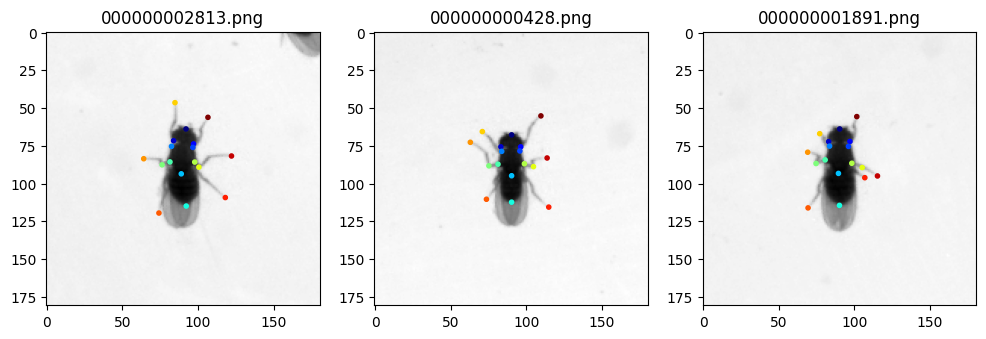

In [52]:
# Show some example images
nimsshow = 3  # number of images to plot
imsshow = np.random.choice(ntrainims,nimsshow)
fig = plt.figure(figsize=(4*nimsshow, 4), dpi=100)  # make the figure bigger
for i in range(nimsshow):
  filestr = trainann['images'][imsshow[i]]['file_name']
  imfile = os.path.join(traindir, filestr)
  im = cv2.imread(imfile, cv2.IMREAD_UNCHANGED)
  plt.subplot(1,nimsshow,i+1)
  plt.imshow(im,cmap='gray')
  x = trainann['annotations'][imsshow[i]]['keypoints'][::3]
  y = trainann['annotations'][imsshow[i]]['keypoints'][1::3]
  plt.scatter(x, y, marker='.', c=np.arange(nlandmarks), cmap='jet')
  plt.title(filestr)
plt.show()

In [53]:
# define a dataset class to load the data

def heatmap2image(hm, cmap='jet', colors=None):
  """
  heatmap2image(hm,cmap='jet',colors=None)
  Creates and returns an image visualization from landmark heatmaps. Each
  landmark is colored according to the input cmap/colors.
  Inputs:
    hm: nlandmarks x height x width ndarray, dtype=float in the range 0 to 1.
    hm[p,i,j] is a score indicating how likely it is that the pth landmark
    is at pixel location (i,j).
    cmap: string.
    Name of colormap for defining colors of landmark points. Used only if colors
    is None.
    Default: 'jet'
    colors: list of length nlandmarks.
    colors[p] is an ndarray of size (4,) indicating the color to use for the
    pth landmark. colors is the output of matplotlib's colormap functions.
    Default: None
  Output:
    im: height x width x 3 ndarray
    Image representation of the input heatmap landmarks.
  """
  hm = np.maximum(0., np.minimum(1. ,hm))
  im = np.zeros((hm.shape[1], hm.shape[2], 3))
  if colors is None:
    if isinstance(cmap, str):
      cmap = matplotlib.cm.get_cmap(cmap)
    colornorm = matplotlib.colors.Normalize(vmin=0, vmax=hm.shape[0])
    colors = cmap(colornorm(np.arange(hm.shape[0])))
  for i in range(hm.shape[0]):
    color = colors[i]
    for c in range(3):
      im[..., c] = im[..., c] + (color[c] * .7 + .3) * hm[i, ...]
  im = np.minimum(1.,im)

  return im


class COCODataset(torch.utils.data.Dataset):
  """
  COCODataset
  Torch Dataset based on the COCO keypoint file format.
  """

  def __init__(self, annfile, datadir=None, label_sigma=3.,
               transform=None, landmarks=None):
    """
    Constructor
    This must be defined in every Torch Dataset and can take any inputs you
    want it to.
    Inputs:
      annfile: string
      Path to json file containing annotations.
      datadir: string
      Path to directory containing images. If None, images are assumed to be in
      the working directory.
      Default: None
      label_sigma: scalar float
      Standard deviation in pixels of Gaussian to be used to make the landmark
      heatmap.
      Default: 3.
      transform: None
      Not used currently
      landmarks: ndarray (or list, something used for indexing into ndarray)
      Indices of landmarks available to use in this dataset. Reducing the
      landmarks used can make training faster and require less memory, and is
      useful for testing code. If None, all landmarks are used.
      Default: None
    """

    # read in the annotations from the json file
    with open(annfile) as f:
      self.ann = json.load(f)
    # where the images are
    self.datadir = datadir

    # landmarks to use
    self.nlandmarks_all = self.ann['annotations'][0]['num_keypoints']
    if landmarks is None:
      self.nlandmarks = self.nlandmarks_all
    else:
      self.nlandmarks = len(landmarks)
    self.landmarks = landmarks

    # for data augmentation/rescaling
    self.transform = transform

    # output will be heatmap images, one per landmark, with Gaussian values
    # around the landmark location -- precompute some stuff for that
    self.label_filter = None
    self.label_filter_r = 1
    self.label_filter_d = 3
    self.label_sigma = label_sigma
    self.init_label_filter()

  def __len__(self):
    """
    Overloaded len function.
    This must be defined in every Torch Dataset and must take only self
    as input.
    Returns the number of examples in the dataset.
    """
    return len(self.ann['images'])

  def __getitem__(self, item):
    """
    Overloaded getitem function.
    This must be defined in every Torch Dataset and must take only self
    and item as input. It returns example number item.
    item: scalar integer.
    The output example is a dict with the following fields:
    image: torch float32 tensor of size ncolors x height x width
    landmarks: nlandmarks x 2 float ndarray
    heatmaps: torch float32 tensor of size nlandmarks x height x width
    id: scalar integer, contains item
    """

    # read in the image for training example item
    # and convert to a torch tensor
    filename = self.ann['images'][item]['file_name']
    if self.datadir is not None:
      filename = os.path.join(self.datadir, filename)
    assert os.path.exists(filename)
    im = torch.from_numpy(cv2.imread(filename, cv2.IMREAD_UNCHANGED))

    # convert to float32 in the range 0. to 1.
    if im.dtype == float:
      pass
    elif im.dtype == torch.uint8:
      im = im.float() / 255.
    elif im.dtype == torch.uint16:
      im = im.float() / 65535.
    else:
      print('Cannot handle im type '+str(im.dtype))
      raise TypeError

    imsz = im.shape
    # convert to a tensor of size ncolors x h x w
    if im.dim() == 3:
      im = torch.transpose(im, [2, 0, 1])  # now 3 x h x w
    else:
      im = torch.unsqueeze(im, 0)  # now 1 x h x w

    # landmark locations
    locs = np.reshape(self.ann['annotations'][item]['keypoints'],
                      [self.nlandmarks_all, 3])
    locs = locs[:, :2]
    if self.landmarks is not None:
      locs = locs[self.landmarks, :]

    # create heatmap target prediction
    heatmaps = self.make_heatmap_target(locs, imsz)

    # return a dict with the following fields:
    # image: torch float32 tensor of size ncolors x height x width
    # landmarks: nlandmarks x 2 float ndarray
    # heatmaps: torch float32 tensor of size nlandmarks x height x width
    # id: scalar integer, contains item
    features = {'image':im,
                'landmarks':locs.astype(np.float32),
                'heatmaps':heatmaps,
                'id':item}

    return features

  def init_label_filter(self):
    """
    init_label_filter(self)
    Helper function
    Create a Gaussian filter for the heatmap target output
    """
    # radius of the filter
    self.label_filter_r = max(int(round(3 * self.label_sigma)), 1)
    # diameter of the filter
    self.label_filter_d = 2 * self.label_filter_r + 1

    # allocate
    self.label_filter = np.zeros([self.label_filter_d, self.label_filter_d])
    # set the middle pixel to 1.
    self.label_filter[self.label_filter_r, self.label_filter_r] = 1.
    # blur with a Gaussian
    self.label_filter = cv2.GaussianBlur(self.label_filter,
                                         (self.label_filter_d,
                                          self.label_filter_d),
                                         self.label_sigma)
    # normalize
    self.label_filter = self.label_filter / np.max(self.label_filter)
    # convert to torch tensor
    self.label_filter = torch.from_numpy(self.label_filter)

  def make_heatmap_target(self, locs, imsz):
    """
    make_heatmap_target(self,locs,imsz):
    Helper function
    Creates the heatmap tensor of size imsz corresponding to landmark locations locs
    Inputs:
      locs: nlandmarks x 2 ndarray
      Locations of landmarks
      imsz: image shape
    Returns:
      target: torch tensor of size nlandmarks x imsz[0] x imsz[1]
      Heatmaps corresponding to locs
    """
    # allocate the tensor
    target = torch.zeros((locs.shape[0], imsz[0], imsz[1]), dtype=torch.float32)
    # loop through landmarks
    for i in range(locs.shape[0]):
      # location of this landmark to the nearest pixel
      x = int(np.round(locs[i, 0])) # losing sub-pixel accuracy
      y = int(np.round(locs[i, 1]))
      # edges of the Gaussian filter to place, minding border of image
      x0 = np.maximum(0, x - self.label_filter_r)
      x1 = np.minimum(imsz[1] - 1, x + self.label_filter_r)
      y0 = np.maximum(0, y - self.label_filter_r)
      y1 = np.minimum(imsz[0] - 1, y + self.label_filter_r)
      # crop filter if it goes outside of the image
      fil_x0 = self.label_filter_r - (x - x0)
      fil_x1 = self.label_filter_d - (self.label_filter_r - (x1 - x))
      fil_y0 = self.label_filter_r - (y - y0)
      fil_y1 = self.label_filter_d - (self.label_filter_r - (y1 - y))
      # copy the filter to the relevant part of the heatmap image
      target[i, y0:y1 + 1, x0:x1 + 1] = self.label_filter[fil_y0:fil_y1 + 1,
                                                          fil_x0:fil_x1 + 1]

    return target

  @staticmethod
  def get_image(d, i=None):
    """
    static function, used for visualization
    COCODataset.get_image(d,i=None)
    Returns an image usable with plt.imshow()
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
    Returns the ith image from the patch as an ndarray plottable with
    plt.imshow()
    """
    if i is None:
      im = np.squeeze(np.transpose(d['image'].numpy(), (1, 2, 0)), axis=2)
    else:
      im = np.squeeze(np.transpose(d['image'][i,...].numpy(), (1, 2, 0)), axis=2)
    return im

  @staticmethod
  def get_landmarks(d, i=None):
    """
    static helper function
    COCODataset.get_landmarks(d,i=None)
    Returns a nlandmarks x 2 ndarray indicating landmark locations.
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
    """
    if i is None:
      locs = d['landmarks']
    else:
      locs = d['landmarks'][i]
    return locs

  @staticmethod
  def get_heatmap_image(d, i, cmap='jet', colors=None):
    """
    static function, used for visualization
    COCODataset.get_heatmap_image(d,i=None)
    Returns an image visualization of heatmaps usable with plt.imshow()
    Inputs:
      d: if i is None, item from a COCODataset.
      if i is a scalar, batch of examples from a COCO Dataset returned
      by a DataLoader.
      i: Index of example into the batch d, or None if d is a single example
      Returns the ith heatmap from the patch as an ndarray plottable with
      plt.imshow()
      cmap: string.
      Name of colormap for defining colors of landmark points. Used only if colors
      is None.
      Default: 'jet'
      colors: list of length nlandmarks.
      colors[p] is an ndarray of size (4,) indicating the color to use for the
      pth landmark. colors is the output of matplotlib's colormap functions.
      Default: None
    Output:
      im: height x width x 3 ndarray
      Image representation of the input heatmap landmarks.
    """
    if i is None:
      hm = d['heatmaps']
    else:
      hm = d['heatmaps'][i, ...]
    hm = hm.numpy()
    im = heatmap2image(hm, cmap=cmap, colors=colors)

    return im

/tmp/ipython-input-54-2476673002.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


{'image': tensor([[[[0.8275, 0.8275, 0.8314,  ..., 0.8196, 0.8196, 0.8157],
          [0.8235, 0.8275, 0.8275,  ..., 0.8196, 0.8196, 0.8157],
          [0.8235, 0.8314, 0.8275,  ..., 0.8157, 0.8157, 0.8157],
          ...,
          [0.8353, 0.8314, 0.8314,  ..., 0.8118, 0.8039, 0.8039],
          [0.8314, 0.8275, 0.8353,  ..., 0.8078, 0.8118, 0.8118],
          [0.8275, 0.8275, 0.8314,  ..., 0.8039, 0.8118, 0.8118]]],


        [[[0.8353, 0.8353, 0.8314,  ..., 0.8314, 0.8196, 0.8275],
          [0.8275, 0.8314, 0.8314,  ..., 0.8275, 0.8275, 0.8314],
          [0.8353, 0.8275, 0.8314,  ..., 0.8275, 0.8275, 0.8275],
          ...,
          [0.7922, 0.7882, 0.7922,  ..., 0.7922, 0.7882, 0.7922],
          [0.7843, 0.7882, 0.7922,  ..., 0.7961, 0.7961, 0.7922],
          [0.7451, 0.7725, 0.7843,  ..., 0.7922, 0.7922, 0.7922]]]]), 'landmarks': tensor([[[ 89.4902,  62.1323],
         [ 82.4667,  69.8355],
         [ 95.6075,  69.1558],
         [ 95.6075,  72.5544],
         [ 83.3592,  73

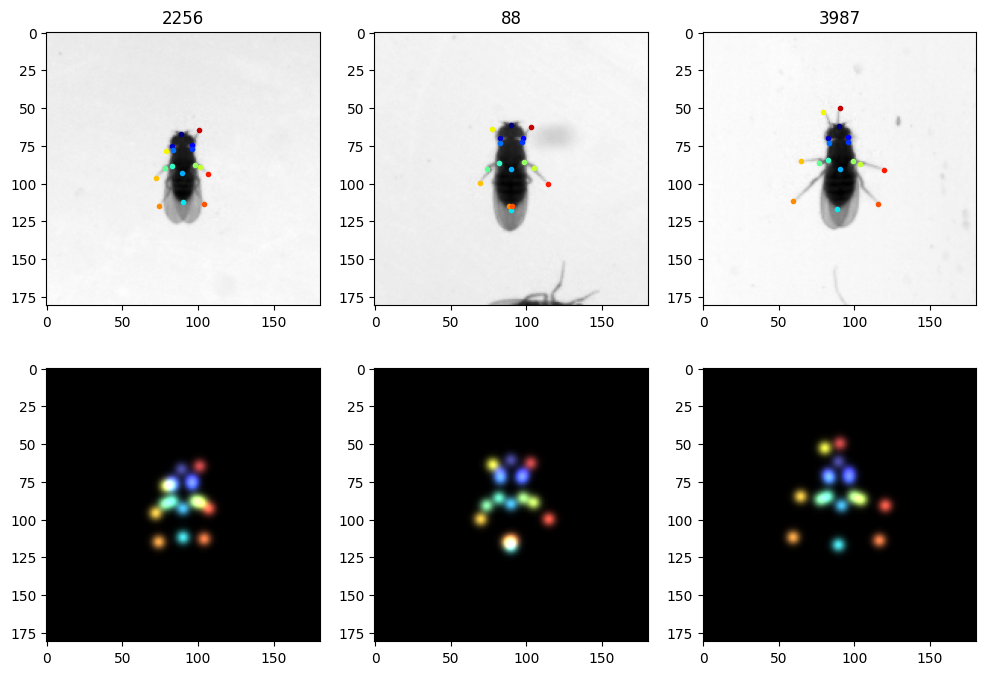

In [54]:
# instantiate train data loader

# only use a subset of the landmarks
#landmarks = np.where(list(map(lambda x: x in ['head_fc','leg_fl_tip','leg_fr_tip'],landmark_names)))[0]
# use all the landmarks
landmarks = None

train_dataset = COCODataset(trainannfile, datadir=traindir, landmarks=landmarks)
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=2,
                                               shuffle=True)

# plot example images using the dataloader
fig = plt.figure(figsize=(nimsshow * 4, 8), dpi=100)

# choose some colors for each landmark
cmap = matplotlib.cm.get_cmap('jet')
colornorm = matplotlib.colors.Normalize(vmin=0, vmax=train_dataset.nlandmarks)
colors = cmap(colornorm(np.arange(train_dataset.nlandmarks)))

count = 0
for i_batch, sample_batch in enumerate(train_dataloader):
  for j in range(len(sample_batch['id'])):
    plt.subplot(2, nimsshow, count + 1)
    # use our helper functions for getting and formatting data from the batch
    im = COCODataset.get_image(sample_batch, j)
    locs = COCODataset.get_landmarks(sample_batch, j)
    plt.imshow(im, cmap='gray')
    for k in range(train_dataset.nlandmarks):
      plt.plot(locs[k, 0], locs[k, 1], marker='.', color=colors[k],
               markerfacecolor=colors[k])
    plt.title('%d'%sample_batch['id'][j])
    hmim = COCODataset.get_heatmap_image(sample_batch, j, colors=colors)
    plt.subplot(2, nimsshow, count + 1 + nimsshow)
    plt.imshow(hmim)
    count += 1
    if count >= nimsshow:
      break
  if count >= nimsshow:
    break

# Show the structure of a batch
print(sample_batch)

---
# Architectures

In [68]:
# ============== 原始单苍蝇预测版本 (已注释) ==============
# class OutConv(nn.Module):
#   def __init__(self, in_channels, out_channels):
#     super(OutConv, self).__init__()
#     self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
#
#   def forward(self, x):
#     return self.conv(x)

# ============== 新多苍蝇预测版本 ==============
class MultiFlyOutConv(nn.Module):
    """输出层：预测多只苍蝇的(x,y)坐标和置信度"""
    def __init__(self, in_channels, max_flies=3):
        super().__init__()
        self.max_flies = max_flies
        # 每只苍蝇需要预测3个值：(x坐标, y坐标, 置信度)
        self.conv = nn.Conv2d(in_channels, max_flies*3, kernel_size=1)

    def forward(self, x):
        # 输出形状: (batch_size, max_flies*3, height, width)
        return self.conv(x)

# ==============================================

# ============== 原始UNet类 (关键部分已注释) ==============
# class UNet(nn.Module):
#   def __init__(self, n_channels, n_landmarks, bilinear=True):
#     super(UNet, self).__init__()
#     self.n_channels = n_channels
#     self.n_landmarks = n_landmarks  # 原始：预测固定数量的关键点
#     self.bilinear = bilinear
#     [...其他初始化代码不变...]
#     self.layer_outc = OutConv(nchannels_up3//factor, self.n_landmarks)
#
#   def forward(self, x):
#     [...前向传播不变...]
#     return logits  # 原始输出形状: (batch, n_landmarks, h, w)
#
#   def output(self, x):
#     return torch.sigmoid(self.forward(x))  # 原始：对整个输出应用sigmoid

# ============== 新UNet类 (多苍蝇预测) ==============
class UNet(nn.Module):
    def __init__(self, n_channels, max_flies=3, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.max_flies = max_flies  # 新：最大预测苍蝇数量
        self.bilinear = bilinear
        self.nchannels_inc = 8

        # 特征提取部分保持不变
        nchannels_inc = self.nchannels_inc
        nchannels_down1 = nchannels_inc*2
        nchannels_down2 = nchannels_down1*2
        nchannels_down3 = nchannels_down2*2
        nchannels_up1 = nchannels_down3//2
        nchannels_up2 = nchannels_up1//2
        nchannels_up3 = nchannels_up2//2

        factor = 2 if bilinear else 1

        self.layer_inc = DoubleConv(n_channels, nchannels_inc)
        self.layer_down1 = Down(nchannels_inc, nchannels_down1)
        self.layer_down2 = Down(nchannels_down1, nchannels_down2)
        self.layer_down3 = Down(nchannels_down2, nchannels_down3//factor)
        self.layer_up1 = Up(nchannels_down3, nchannels_up1//factor, bilinear)
        self.layer_up2 = Up(nchannels_up1, nchannels_up2//factor, bilinear)
        self.layer_up3 = Up(nchannels_up2, nchannels_up3//factor, bilinear)

        # 修改输出层
        self.layer_outc = MultiFlyOutConv(nchannels_up3//factor, max_flies)

    def forward(self, x, verbose=False):
        # 特征提取部分保持不变
        x1 = self.layer_inc(x)
        x2 = self.layer_down1(x1)
        x3 = self.layer_down2(x2)
        x4 = self.layer_down3(x3)
        x = self.layer_up1(x4, x3)
        x = self.layer_up2(x, x2)
        x = self.layer_up3(x, x1)

        # 新输出处理
        logits = self.layer_outc(x)
        # 重塑为 (batch, max_flies, 3, h, w)
        return logits.view(logits.shape[0], self.max_flies, 3, logits.shape[2], logits.shape[3])

    def output(self, x, verbose=False):
        output = self.forward(x, verbose)
        # 对坐标和置信度分别应用sigmoid
        output[:, :, :2] = torch.sigmoid(output[:, :, :2])  # 坐标归一化到[0,1]
        output[:, :, 2] = torch.sigmoid(output[:, :, 2])    # 置信度概率化
        return output

    # 保持原有的__str__和__repr__方法不变
    def __str__(self):
        s = ''
        s += 'inc: '+str(self.layer_inc)+'\n'
        s += 'down1: '+str(self.layer_down1)+'\n'
        s += 'down2: '+str(self.layer_down2)+'\n'
        s += 'down3: '+str(self.layer_down3)+'\n'
        s += 'up1: '+str(self.layer_up1)+'\n'
        s += 'up2: '+str(self.layer_up2)+'\n'
        s += 'up3: '+str(self.layer_up3)+'\n'
        s += 'outc: '+str(self.layer_outc)+'\n'
        return s

    def __repr__(self):
        return str(self)

# ==============================================

# ============== 原始关键点转换函数 (已注释) ==============
# def heatmap2landmarks(hms):
#   idx = np.argmax(hms.reshape(hms.shape[:-2] + (hms.shape[-2]*hms.shape[-1], )),
#                   axis=-1)
#   locs = np.zeros(hms.shape[:-2] + (2, ))
#   locs[...,1],locs[...,0] = np.unravel_index(idx,hms.shape[-2:])
#   return locs

# ============== 新多苍蝇检测函数 ==============
def detect_multiple_flies(hms, image_size, confidence_thresh=0.5, nms_thresh=10):
    """
    从网络输出中检测多只苍蝇位置
    参数:
        hms: (max_flies, 3, height, width) 网络输出
        image_size: (width, height) 原始图像尺寸
        confidence_thresh: 置信度阈值
        nms_thresh: 非极大值抑制距离阈值(像素)
    返回:
        检测到的苍蝇位置列表 [(x1,y1), (x2,y2), ...]
    """
    detected_flies = []
    width, height = image_size

    # 处理每只苍蝇的预测
    for fly_pred in hms:
        conf_map = fly_pred[2]  # 置信度通道
        max_conf = conf_map.max()

        if max_conf > confidence_thresh:
            # 找到置信度最高的位置
            y, x = (conf_map == max_conf).nonzero()[0]

            # 获取归一化坐标并转换到图像尺寸
            x_norm = fly_pred[0, y, x].item()
            y_norm = fly_pred[1, y, x].item()
            x_img = x_norm * width
            y_img = y_norm * height

            detected_flies.append((x_img, y_img, max_conf.item()))

    # 非极大值抑制 (NMS)
    if len(detected_flies) > 1:
        detected_flies.sort(key=lambda x: x[2], reverse=True)  # 按置信度排序
        keep = []

        while detected_flies:
            current = detected_flies.pop(0)
            keep.append(current)

            # 移除附近重复检测
            to_remove = []
            for i, other in enumerate(detected_flies):
                dist = ((current[0]-other[0])**2 + (current[1]-other[1])**2)**0.5
                if dist < nms_thresh:
                    to_remove.append(i)

            for i in sorted(to_remove, reverse=True):
                detected_flies.pop(i)

        detected_flies = keep

    return [(x, y) for x, y, _ in detected_flies]

网络输出形状: torch.Size([2, 3, 3, 181, 181])


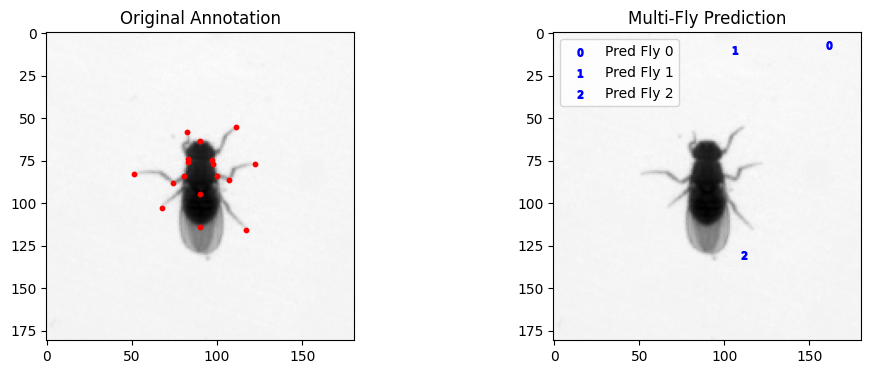

In [69]:
# ============== 原始单苍蝇预测版本 (已注释) ==============
# net = UNet(n_channels=imsize[-1], n_landmarks=train_dataset.nlandmarks)
# net.to(device=device)

# ============== 新多苍蝇预测版本 ==============
# 初始化网络 - 现在预测多只苍蝇而不是关键点
max_flies = 3  # 设置最大预测苍蝇数量
net = UNet(n_channels=imsize[-1], max_flies=max_flies)
net.to(device=device)

# 测试网络输出
batch = next(iter(train_dataloader))
with torch.no_grad():
    # 输出形状: (batch_size, max_flies, 3, height, width)
    hms0 = net.output(batch['image'].to(device=device), verbose=True)
    print(f"网络输出形状: {hms0.shape}")  # 调试用

# 可视化第一个样本的预测
sample_idx = 0  # 选择batch中的第一个样本
fig = plt.figure(figsize=(12, 4), dpi=100)

# 原始标注可视化
plt.subplot(1, 2, 1)
im = COCODataset.get_image(batch, sample_idx)
plt.imshow(im, cmap='gray')
locs = COCODataset.get_landmarks(batch, sample_idx)
plt.scatter(locs[:, 0], locs[:, 1], c='red', s=10, label='Ground Truth')
plt.title('Original Annotation')

# 多苍蝇预测可视化
plt.subplot(1, 2, 2)
plt.imshow(im, cmap='gray')
# 从网络输出中提取预测的苍蝇位置
pred_flies = detect_multiple_flies(hms0[sample_idx].cpu(),
                                  (im.shape[1], im.shape[0]),
                                  confidence_thresh=0.3)
# 绘制预测结果
for i, (x, y) in enumerate(pred_flies):
    plt.scatter(x, y, c='blue', s=30, marker=f'${i}$', label=f'Pred Fly {i}')
plt.title('Multi-Fly Prediction')
plt.legend()
plt.show()

# ============== 原始可视化代码 (已注释) ==============
# fig = plt.figure(figsize=(12, 4*len(batch['id'])), dpi=100)
# PlotLabelAndPrediction(batch, hms0)

In [70]:
# ============== 原始单苍蝇预测版本 (已注释) ==============
# savefile = '/content/drive/My Drive/PoseEstimationNets/UNet20210510T140305/Final_epoch4.pth'
# savefile = None
# loadepoch = 0
# if savefile is not None:
#   net.load_state_dict(
#       torch.load(savefile, map_location=device)
#   )
#   m = re.search('[^\d](?P<epoch>\d+)\.pth$', savefile)
#   if m is None:
#     print('Could not parse epoch from file name')
#   else:
#     loadepoch = int(m['epoch'])
#     print(f"Parsed epoch from loaded net file name: {loadepoch}")
#   net.to(device=device)

# ============== 新多苍蝇预测版本 ==============
savefile = None  # 默认不加载预训练模型
loadepoch = 0

# 可选的模型加载路径（根据实际情况修改）
# savefile = '/path/to/your/saved_model.pth'

if savefile is not None:
    try:
        # 加载模型状态字典
        state_dict = torch.load(savefile, map_location=device)

        # 处理可能的兼容性问题
        if 'module.' in list(state_dict.keys())[0]:  # 处理DataParallel保存的模型
            state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

        # 特别处理从旧版单苍蝇模型迁移的情况
        if 'layer_outc.conv.weight' in state_dict:
            old_weight = state_dict['layer_outc.conv.weight']
            if old_weight.shape[0] != max_flies * 3:  # 检查输出通道是否匹配
                print(f"Warning: Output channels mismatch! Expected {max_flies*3}, got {old_weight.shape[0]}")
                print("Initializing output layer randomly and loading compatible weights...")
                # 只加载兼容的部分权重
                net.load_state_dict(state_dict, strict=False)
            else:
                net.load_state_dict(state_dict)
        else:
            net.load_state_dict(state_dict)

        # 解析epoch数
        m = re.search(r'(?P<epoch>\d+)\.pth$', savefile)
        if m is None:
            print('Could not parse epoch from file name')
        else:
            loadepoch = int(m.group('epoch'))
            print(f"Loaded model from epoch {loadepoch}")

        net.to(device)
        print(f"Successfully loaded model from {savefile}")

    except Exception as e:
        print(f"Error loading model from {savefile}: {str(e)}")
        print("Continuing with randomly initialized model...")
        loadepoch = 0
else:
    print("No pretrained model specified, training from scratch...")

No pretrained model specified, training from scratch...


In [72]:
# ============== 修正后的多苍蝇损失函数 ==============
class MultiFlyLoss(nn.Module):
    def __init__(self, pos_weight=1.0, neg_weight=0.5):
        super().__init__()
        self.pos_weight = pos_weight
        self.neg_weight = neg_weight
        self.coord_loss = nn.MSELoss()
        self.conf_loss = nn.BCEWithLogitsLoss()  # 修改为BCEWithLogitsLoss

    def forward(self, predictions, heatmaps):
        """
        predictions: (batch, max_flies, 3, h, w) - 3通道分别是x,y,confidence
        heatmaps: (batch, nlandmarks, h, w) - 原始热图标注
        """
        batch_size = predictions.size(0)
        total_loss = 0

        for b in range(batch_size):
            # 找到热图中每个关键点的位置
            for landmark_idx in range(heatmaps.size(1)):
                hm = heatmaps[b, landmark_idx]
                if hm.max() == 0:  # 跳过未标注的关键点
                    continue

                # 获取真实位置(转换为0-1范围)
                pos = (hm == hm.max()).nonzero()[0]
                y_true, x_true = pos[0], pos[1]
                x_true_norm = x_true.float() / hm.size(1)
                y_true_norm = y_true.float() / hm.size(0)

                # 计算每只苍蝇预测与该关键点的匹配程度
                best_loss = float('inf')
                for f in range(predictions.size(1)):
                    # 坐标预测
                    pred_x = predictions[b, f, 0, y_true, x_true]
                    pred_y = predictions[b, f, 1, y_true, x_true]

                    # 置信度预测(使用sigmoid前的结果)
                    pred_conf = predictions[b, f, 2, :, :]  # 整个置信度图

                    # 计算坐标损失
                    coord_loss = self.coord_loss(pred_x, x_true_norm) + \
                                 self.coord_loss(pred_y, y_true_norm)

                    # 计算置信度损失(正样本)
                    target_conf = torch.zeros_like(pred_conf)
                    target_conf[y_true, x_true] = 1  # 只在真实位置设为1
                    conf_loss = self.conf_loss(pred_conf, target_conf)

                    # 总损失
                    current_loss = coord_loss + self.pos_weight * conf_loss
                    if current_loss < best_loss:
                        best_loss = current_loss

                total_loss += best_loss

                # 负样本处理(其他预测的置信度应该低)
                for f in range(predictions.size(1)):
                    neg_conf = predictions[b, f, 2, :, :]
                    neg_target = torch.zeros_like(neg_conf)
                    neg_loss = self.conf_loss(neg_conf, neg_target)
                    total_loss += self.neg_weight * neg_loss

        return total_loss / (batch_size * max(1, heatmaps.size(1)))

# ============== 修正后的训练循环 ==============
criterion = MultiFlyLoss(pos_weight=1.0, neg_weight=0.5)

for epoch in range(loadepoch, nepochs):
    net.train()
    epoch_loss = 0

    with tqdm(total=len(train_dataloader), desc=f'Epoch {epoch+1}/{nepochs}', unit='batch') as pbar:
        for batch_idx, batch in enumerate(train_dataloader):
            imgs = batch['image'].to(device, dtype=torch.float32)
            hm_labels = batch['heatmaps'].to(device, dtype=torch.float32)

            optimizer.zero_grad()

            # 前向传播(使用forward而不是output以获取原始输出)
            raw_outputs = net(imgs)  # (batch, max_flies, 3, h, w)

            # 计算损失
            loss = criterion(raw_outputs, hm_labels)

            # 反向传播
            loss.backward()
            nn.utils.clip_grad_value_(net.parameters(), 0.1)
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            pbar.update(1)

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch {epoch+1} train loss: {avg_epoch_loss:.4f}')
    epoch_losses[epoch] = avg_epoch_loss

    # 保存检查点
    if (epoch + 1) % nepochs_per_save == 0:
        save_path = os.path.join(checkpointdir, f'multifly_epoch{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }, save_path)
        print(f'Saved checkpoint to {save_path}')

# 保存最终模型
final_path = os.path.join(checkpointdir, f'multifly_final_epoch{nepochs}.pth')
torch.save(net.state_dict(), final_path)
print(f'Training complete. Final model saved to {final_path}')

Epoch 1/3: 100%|██████████| 1898/1898 [16:06<00:00,  1.96batch/s, loss=3.2645]


Epoch 1 train loss: 2.9000
Saved checkpoint to /content/PoseEstimationNets/UNet20250715T023428/multifly_epoch1.pth


Epoch 2/3: 100%|██████████| 1898/1898 [16:03<00:00,  1.97batch/s, loss=2.9401]


Epoch 2 train loss: 2.8994
Saved checkpoint to /content/PoseEstimationNets/UNet20250715T023428/multifly_epoch2.pth


Epoch 3/3: 100%|██████████| 1898/1898 [16:39<00:00,  1.90batch/s, loss=2.9172]

Epoch 3 train loss: 2.9000
Saved checkpoint to /content/PoseEstimationNets/UNet20250715T023428/multifly_epoch3.pth
Training complete. Final model saved to /content/PoseEstimationNets/UNet20250715T023428/multifly_final_epoch3.pth


Train predictions shape: torch.Size([2, 3, 3, 181, 181])


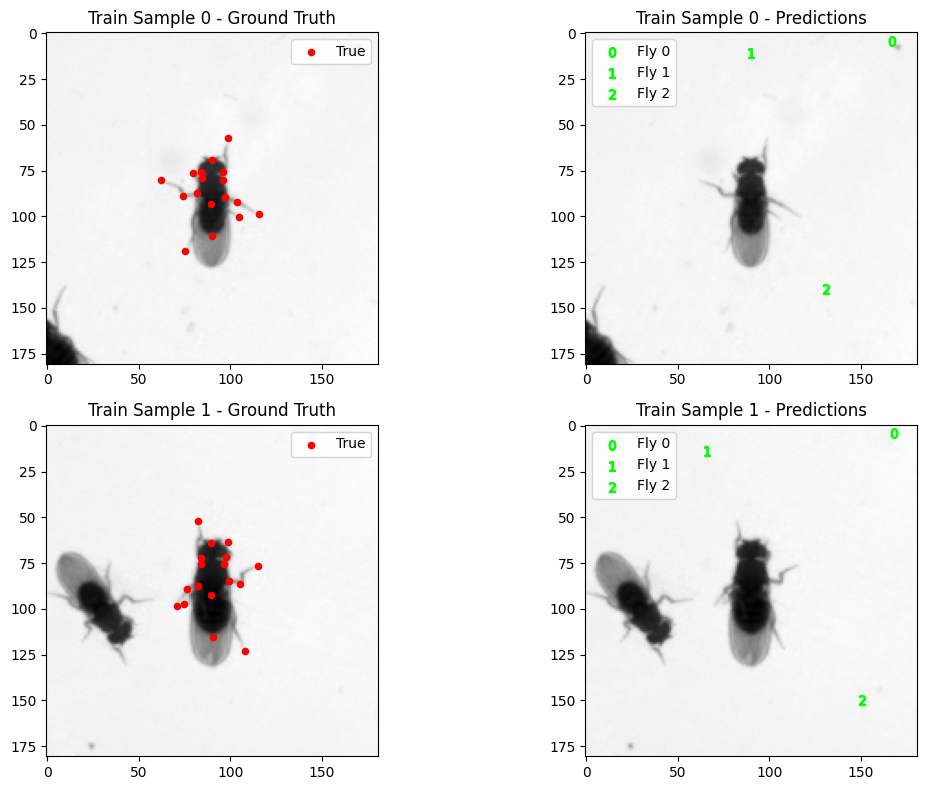

Val predictions shape: torch.Size([2, 3, 3, 181, 181])


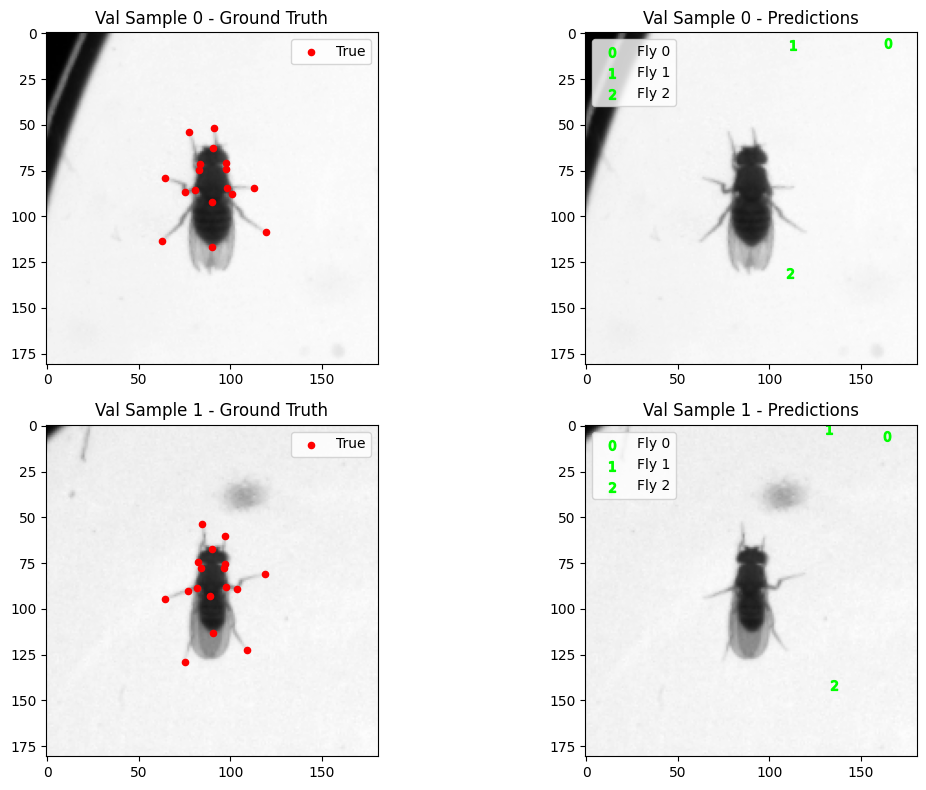


Prediction Statistics:
Max confidence: 0.9926
Mean confidence: 0.5874
Active predictions (>0.5 conf): 191299

Prediction Statistics:
Max confidence: 0.9892
Mean confidence: 0.5904
Active predictions (>0.5 conf): 190424


In [73]:
# ============== 原始验证代码 (已注释) ==============
# net.eval()
# batch = next(iter(train_dataloader))
# with torch.no_grad():
#   train_hms1 = torch.sigmoid(net(batch['image'].to(device)))
#
# fig=plt.figure(figsize=(12, 4*train_hms1.shape[0]), dpi= 100)
# PlotLabelAndPrediction(batch,train_hms1,title_string='Train ')
#
# batch = next(iter(val_dataloader))
# with torch.no_grad():
#   val_hms1 = net.output(batch['image'].to(device))
# fig = plt.figure(figsize=(12, 4 * val_hms1.shape[0]), dpi=100)
# PlotLabelAndPrediction(batch, val_hms1, title_string='Val ')

# ============== 新多苍蝇预测验证版本 ==============
def visualize_predictions(batch, predictions, title):
    """
    可视化多苍蝇预测结果
    参数:
        batch: 数据批次
        predictions: 网络输出 (batch, max_flies, 3, h, w)
        title: 图像标题前缀
    """
    batch_size = predictions.shape[0]
    fig = plt.figure(figsize=(12, 4 * batch_size), dpi=100)

    for i in range(batch_size):
        # 获取原始图像
        img = COCODataset.get_image(batch, i)
        h, w = img.shape

        # 获取真实标注
        true_locs = COCODataset.get_landmarks(batch, i)

        # 获取预测结果
        pred_flies = detect_multiple_flies(predictions[i].cpu(),
                                         (w, h),
                                         confidence_thresh=0.3)

        # 绘制原始图像和标注
        plt.subplot(batch_size, 2, i*2 + 1)
        plt.imshow(img, cmap='gray')
        plt.scatter(true_locs[:, 0], true_locs[:, 1],
                   c='red', s=20, marker='o', label='True')
        plt.title(f'{title}Sample {i} - Ground Truth')
        plt.legend()

        # 绘制预测结果
        plt.subplot(batch_size, 2, i*2 + 2)
        plt.imshow(img, cmap='gray')
        for fly_idx, (x, y) in enumerate(pred_flies):
            plt.scatter(x, y, c='lime', s=50,
                       marker=f'${fly_idx}$', label=f'Fly {fly_idx}')
        plt.title(f'{title}Sample {i} - Predictions')
        plt.legend()

    plt.tight_layout()
    plt.show()

# 验证训练集样本
net.eval()
batch = next(iter(train_dataloader))
with torch.no_grad():
    # 使用output方法获取已归一化的预测结果
    train_preds = net.output(batch['image'].to(device))  # (batch, max_flies, 3, h, w)
    print(f"Train predictions shape: {train_preds.shape}")

visualize_predictions(batch, train_preds, 'Train ')

# 验证验证集样本
batch = next(iter(val_dataloader))
with torch.no_grad():
    val_preds = net.output(batch['image'].to(device))
    print(f"Val predictions shape: {val_preds.shape}")

visualize_predictions(batch, val_preds, 'Val ')

# ============== 新增统计信息打印 ==============
def print_prediction_stats(predictions):
    """打印预测结果的统计信息"""
    print("\nPrediction Statistics:")
    print(f"Max confidence: {predictions[:,:,2].max().item():.4f}")
    print(f"Mean confidence: {predictions[:,:,2].mean().item():.4f}")
    print(f"Active predictions (>0.5 conf): {torch.sum(predictions[:,:,2] > 0.5).item()}")

print_prediction_stats(train_preds)
print_prediction_stats(val_preds)

---
# Evaluation

In [74]:
# ============== 原始评估代码 (已注释) ==============
# def eval_net(net, loader):
#   net.eval()
#   n_val = len(loader) * loader.batch_size
#   errs = None
#   count = 0
#
#   for batch in loader:
#     with torch.no_grad():
#       hm_preds = torch.sigmoid(net(batch['image'].to(device))).cpu().numpy()
#
#     idx = np.argmax(hm_preds.reshape((hm_preds.shape[0],
#                                       hm_preds.shape[1],
#                                       hm_preds.shape[2] * hm_preds.shape[3])),
#                     axis=2)
#     loc_preds = np.zeros((hm_preds.shape[0], hm_preds.shape[1], 2))
#     loc_preds[:, :, 1], loc_preds[:, :, 0] = np.unravel_index(idx,
#                                                               hm_preds.shape[2:])
#
#     loc_labels = batch['landmarks'].numpy()
#     l2err = np.sqrt(np.sum((loc_preds - loc_labels)**2., axis=2))
#     idscurr = batch['id'].numpy()
#
#     if errs is None:
#       errs = np.zeros((n_val, l2err.shape[1]))
#       errs[:] = np.nan
#       ids = np.zeros(n_val, dtype=int)
#
#     errs[count:(count + l2err.shape[0]), :] = l2err
#     ids[count:(count + l2err.shape[0])] = idscurr
#     count += l2err.shape[0]
#
#   errs = errs[:count, :]
#   ids = ids[:count]
#
#   net.train()
#
#   return errs, ids

# ============== 新多苍蝇预测评估版本 ==============
def eval_multifly_net(net, loader, confidence_thresh=0.3):
    """
    评估多苍蝇预测网络的性能
    参数:
        net: 训练好的网络
        loader: 数据加载器
        confidence_thresh: 置信度阈值
    返回:
        errs: 每个关键点的平均误差 (n_samples, n_landmarks)
        ids: 对应的样本ID
    """
    net.eval()
    n_val = len(loader.dataset)
    errs = None
    ids = np.zeros(n_val, dtype=int)
    count = 0

    for batch_idx, batch in enumerate(loader):
        with torch.no_grad():
            # 获取网络输出 (batch, max_flies, 3, h, w)
            outputs = net.output(batch['image'].to(device))

        # 获取图像原始尺寸
        img_size = (batch['image'].shape[3], batch['image'].shape[2])  # (width, height)

        # 获取真实标注
        loc_labels = batch['landmarks'].numpy()  # (batch, n_landmarks, 2)

        batch_errs = np.zeros((len(batch['id']), loc_labels.shape[1]))
        batch_errs[:] = np.nan

        for i in range(outputs.shape[0]):  # 遍历batch中的每个样本
            # 检测苍蝇位置
            pred_flies = detect_multiple_flies(outputs[i].cpu(), img_size, confidence_thresh)

            if not pred_flies:
                continue  # 没有检测到苍蝇，保持nan

            # 计算每个关键点与最近预测苍蝇的距离
            for landmark_idx in range(loc_labels.shape[1]):
                true_x, true_y = loc_labels[i, landmark_idx]
                min_dist = float('inf')

                for pred_x, pred_y in pred_flies:
                    dist = np.sqrt((true_x - pred_x)**2 + (true_y - pred_y)**2)
                    if dist < min_dist:
                        min_dist = dist

                if min_dist != float('inf'):
                    batch_errs[i, landmark_idx] = min_dist

        # 存储结果
        if errs is None:
            errs = np.zeros((n_val, loc_labels.shape[1]))
            errs[:] = np.nan

        batch_size = len(batch['id'])
        errs[count:count+batch_size] = batch_errs
        ids[count:count+batch_size] = batch['id'].numpy()
        count += batch_size

    net.train()
    return errs[:count], ids[:count]

# 评估训练集和验证集
l2err_per_landmark_val, val_ids = eval_multifly_net(net, val_dataloader)
l2err_per_landmark_train, train_ids = eval_multifly_net(net, train_dataloader)

# ============== 新增评估统计 ==============
def print_evaluation_stats(errs, name):
    """打印评估统计信息"""
    print(f"\n{name} Evaluation Stats:")
    print(f"Mean error: {np.nanmean(errs):.2f} px")
    print(f"Median error: {np.nanmedian(errs):.2f} px")
    print(f"Detection rate: {1 - np.mean(np.isnan(errs)):.1%}")

    # 按关键点统计
    if errs.shape[1] > 1:  # 如果有多个关键点
        print("\nPer-landmark stats:")
        for i in range(errs.shape[1]):
            landmark_err = errs[:, i]
            valid_err = landmark_err[~np.isnan(landmark_err)]
            if len(valid_err) > 0:
                print(f"Landmark {i}: {np.mean(valid_err):.2f} ± {np.std(valid_err):.2f} px")
            else:
                print(f"Landmark {i}: No valid predictions")

print_evaluation_stats(l2err_per_landmark_train, "Training Set")
print_evaluation_stats(l2err_per_landmark_val, "Validation Set")


Training Set Evaluation Stats:
Mean error: 56.98 px
Median error: 59.06 px
Detection rate: 100.0%

Per-landmark stats:
Landmark 0: 54.73 ± 7.31 px
Landmark 1: 60.29 ± 10.04 px
Landmark 2: 61.04 ± 8.14 px
Landmark 3: 61.87 ± 9.04 px
Landmark 4: 61.76 ± 10.74 px
Landmark 5: 57.64 ± 15.41 px
Landmark 6: 46.10 ± 16.73 px
Landmark 7: 62.58 ± 14.21 px
Landmark 8: 64.18 ± 15.86 px
Landmark 9: 58.80 ± 13.45 px
Landmark 10: 55.48 ± 13.17 px
Landmark 11: 52.43 ± 10.09 px
Landmark 12: 67.95 ± 18.50 px
Landmark 13: 58.63 ± 17.71 px
Landmark 14: 38.56 ± 19.40 px
Landmark 15: 53.72 ± 13.47 px
Landmark 16: 52.95 ± 9.83 px

Validation Set Evaluation Stats:
Mean error: 57.17 px
Median error: 59.22 px
Detection rate: 100.0%

Per-landmark stats:
Landmark 0: 54.21 ± 7.57 px
Landmark 1: 59.86 ± 10.42 px
Landmark 2: 60.80 ± 8.34 px
Landmark 3: 61.82 ± 9.19 px
Landmark 4: 61.40 ± 11.08 px
Landmark 5: 58.06 ± 15.38 px
Landmark 6: 47.08 ± 17.06 px
Landmark 7: 62.76 ± 14.35 px
Landmark 8: 64.41 ± 15.95 px
Land

## Error distribution

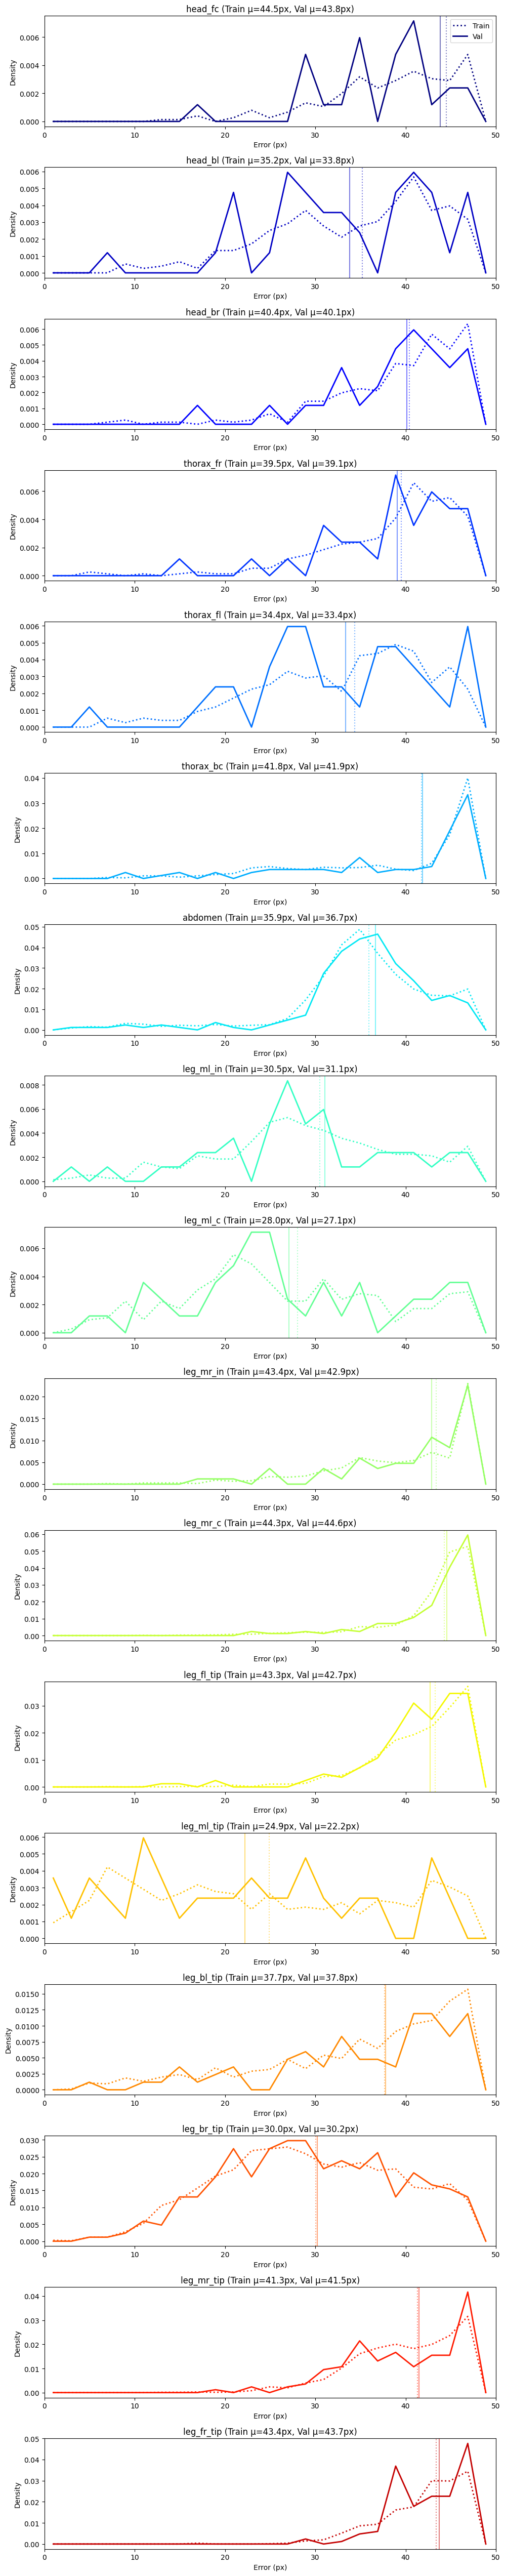


Overall Error Statistics (px):
Landmark        Train Mean Train Med  Val Mean   Val Med   
head_fc         44.49      48.42      43.85      48.48     
head_bl         35.19      37.07      33.78      32.88     
head_br         40.41      42.01      40.13      41.17     
thorax_fr       39.54      41.02      39.08      40.80     
thorax_fl       34.39      35.91      33.39      33.57     
thorax_bc       41.76      46.41      41.89      46.18     
abdomen         35.94      35.80      36.67      36.50     
leg_ml_in       30.51      29.77      31.08      29.48     
leg_ml_c        28.05      25.83      27.09      24.56     
 leg_mr_in      43.36      47.06      42.91      46.06     
leg_mr_c        44.30      45.62      44.59      46.08     
leg_fl_tip      43.26      44.86      42.70      43.74     
leg_ml_tip      24.89      23.17      22.21      21.89     
leg_bl_tip      37.67      41.04      37.80      41.10     
leg_br_tip      30.04      29.49      30.25      29.74     
leg_mr_t

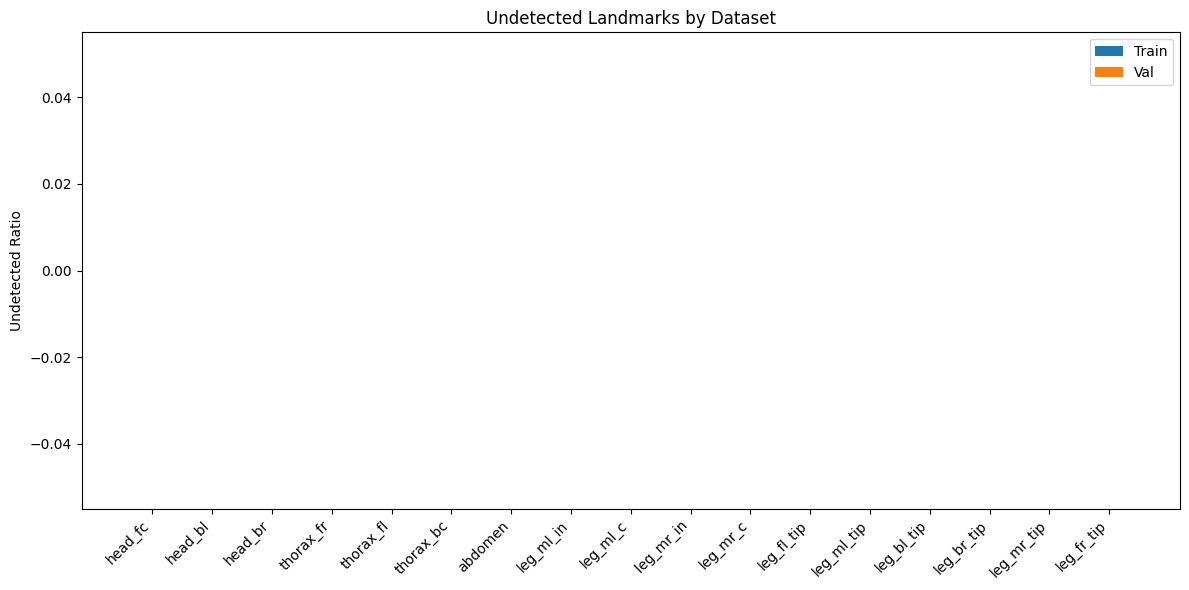

In [75]:
# ============== 原始误差分布代码 (已注释) ==============
# nbins = 25
# bin_edges = np.linspace(0, np.percentile(l2err_per_landmark_val, 99.),
#                         nbins + 1)
# [...其余原始代码...]

# ============== 新多苍蝇预测误差分布版本 ==============
def plot_error_distribution(train_errs, val_errs, landmark_names, colors,
                          max_error=50, nbins=25):
    """
    绘制多苍蝇预测的误差分布

    参数:
        train_errs: 训练集误差数组 (n_samples, n_landmarks)
        val_errs: 验证集误差数组 (n_samples, n_landmarks)
        landmark_names: 关键点名称列表
        colors: 每个关键点的颜色
        max_error: 最大显示误差值(像素)
        nbins: 直方图bin数量
    """
    # 过滤掉nan值并限制最大误差
    train_errs = np.clip(np.nan_to_num(train_errs, nan=max_error), 0, max_error)
    val_errs = np.clip(np.nan_to_num(val_errs, nan=max_error), 0, max_error)

    # 创建统一的bin边缘
    all_errs = np.concatenate([train_errs.ravel(), val_errs.ravel()])
    bin_edges = np.linspace(0, np.percentile(all_errs[all_errs < max_error], 99),
                       nbins + 1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    bin_edges[-1] = np.inf  # 最后一个bin包含所有大误差

    # 计算每个关键点的误差分布
    n_landmarks = train_errs.shape[1]
    fig = plt.figure(figsize=(10, 3 * n_landmarks), dpi=100)

    for i in range(n_landmarks):
        plt.subplot(n_landmarks, 1, i + 1)

        # 计算直方图
        train_hist, _ = np.histogram(train_errs[:, i], bins=bin_edges, density=True)
        val_hist, _ = np.histogram(val_errs[:, i], bins=bin_edges, density=True)

        # 绘制曲线
        plt.plot(bin_centers, train_hist, ':',
                color=colors[i], label='Train', linewidth=2)
        plt.plot(bin_centers, val_hist, '-',
                color=colors[i], label='Val', linewidth=2)

        # 标注统计信息
        train_mean = np.mean(train_errs[:, i][train_errs[:, i] < max_error])
        val_mean = np.mean(val_errs[:, i][val_errs[:, i] < max_error])
        plt.axvline(train_mean, color=colors[i], linestyle=':', alpha=0.5)
        plt.axvline(val_mean, color=colors[i], linestyle='-', alpha=0.5)

        # 设置标题和图例
        title = f"{landmark_names[i]} (Train μ={train_mean:.1f}px, Val μ={val_mean:.1f}px)"
        plt.title(title)
        plt.xlabel('Error (px)')
        plt.ylabel('Density')
        if i == 0:
            plt.legend()

        # 设置一致的x轴范围
        plt.xlim(0, max_error)

    plt.tight_layout()
    plt.show()

    # 打印整体统计
    print(f"\nOverall Error Statistics (px):")
    print(f"{'Landmark':<15} {'Train Mean':<10} {'Train Med':<10} {'Val Mean':<10} {'Val Med':<10}")
    for i in range(n_landmarks):
        train_err = train_errs[:, i][train_errs[:, i] < max_error]
        val_err = val_errs[:, i][val_errs[:, i] < max_error]
        print(f"{landmark_names[i]:<15} {np.mean(train_err):<10.2f} {np.median(train_err):<10.2f} "
              f"{np.mean(val_err):<10.2f} {np.median(val_err):<10.2f}")

# 使用示例
plot_error_distribution(
    l2err_per_landmark_train,
    l2err_per_landmark_val,
    landmark_names=[landmark_names[i] for i in (landmarks if landmarks else range(len(landmark_names)))],
    colors=colors,
    max_error=50  # 设置最大显示误差为50像素
)

# ============== 新增未检测比例分析 ==============
def plot_detection_rates(train_errs, val_errs, landmark_names):
    """绘制每个关键点的未检测比例"""
    train_undetected = np.isnan(l2err_per_landmark_train).mean(axis=0)
    val_undetected = np.isnan(l2err_per_landmark_val).mean(axis=0)

    x = np.arange(len(landmark_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, train_undetected, width, label='Train')
    rects2 = ax.bar(x + width/2, val_undetected, width, label='Val')

    ax.set_ylabel('Undetected Ratio')
    ax.set_title('Undetected Landmarks by Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(landmark_names, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

plot_detection_rates(l2err_per_landmark_train, l2err_per_landmark_val,
                    [landmark_names[i] for i in (landmarks if landmarks else range(len(landmark_names)))])

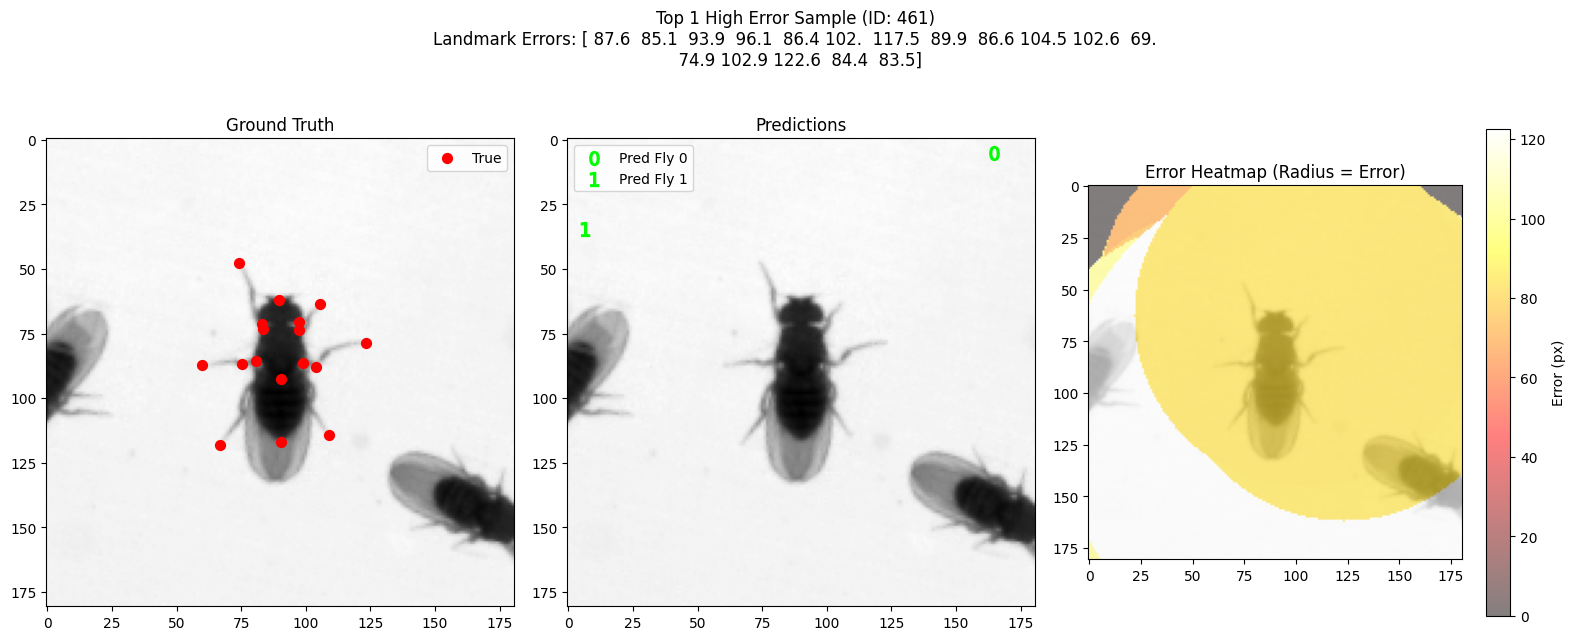

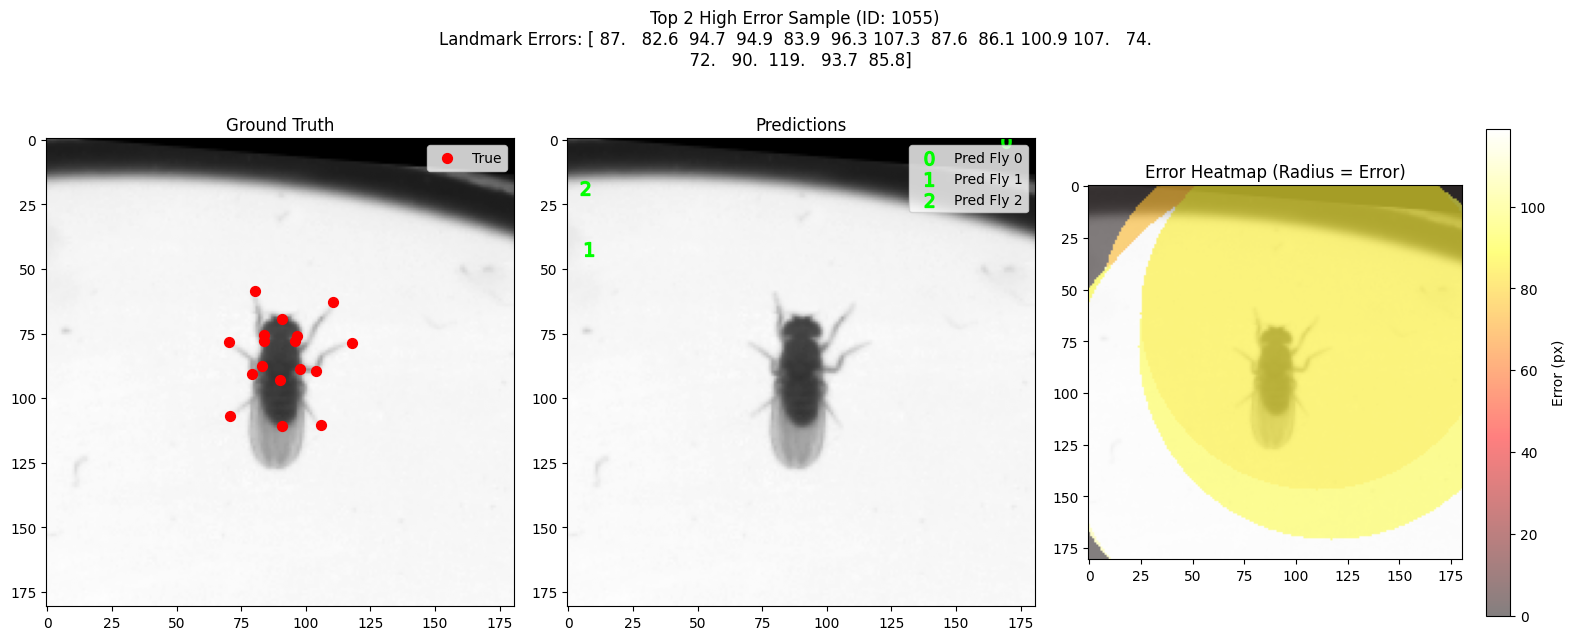

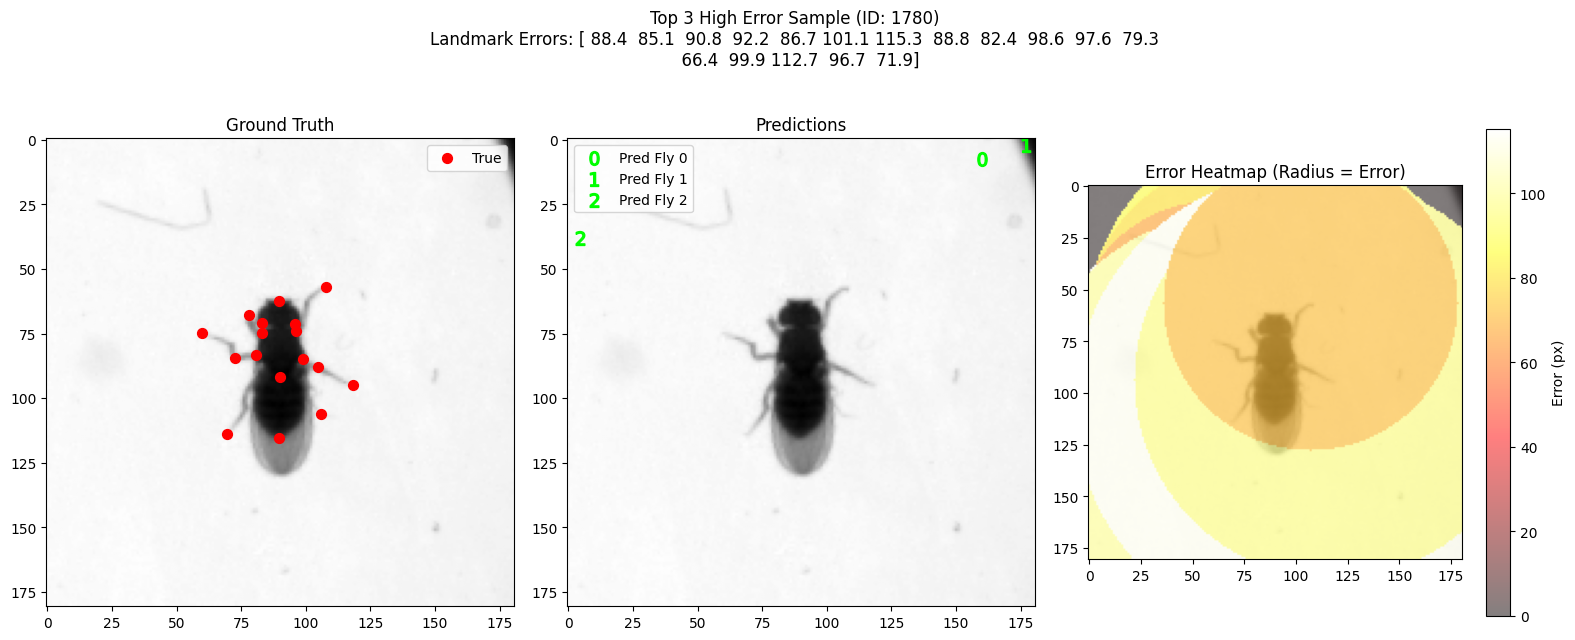

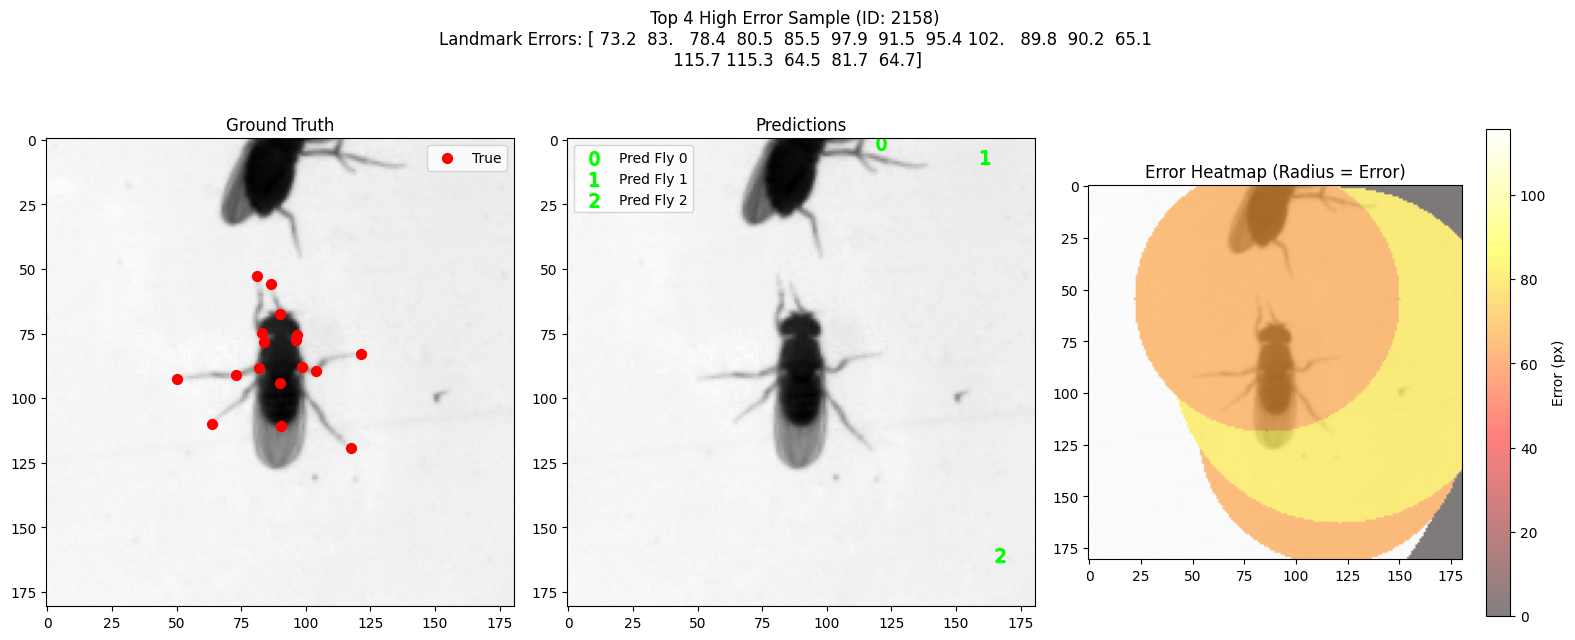

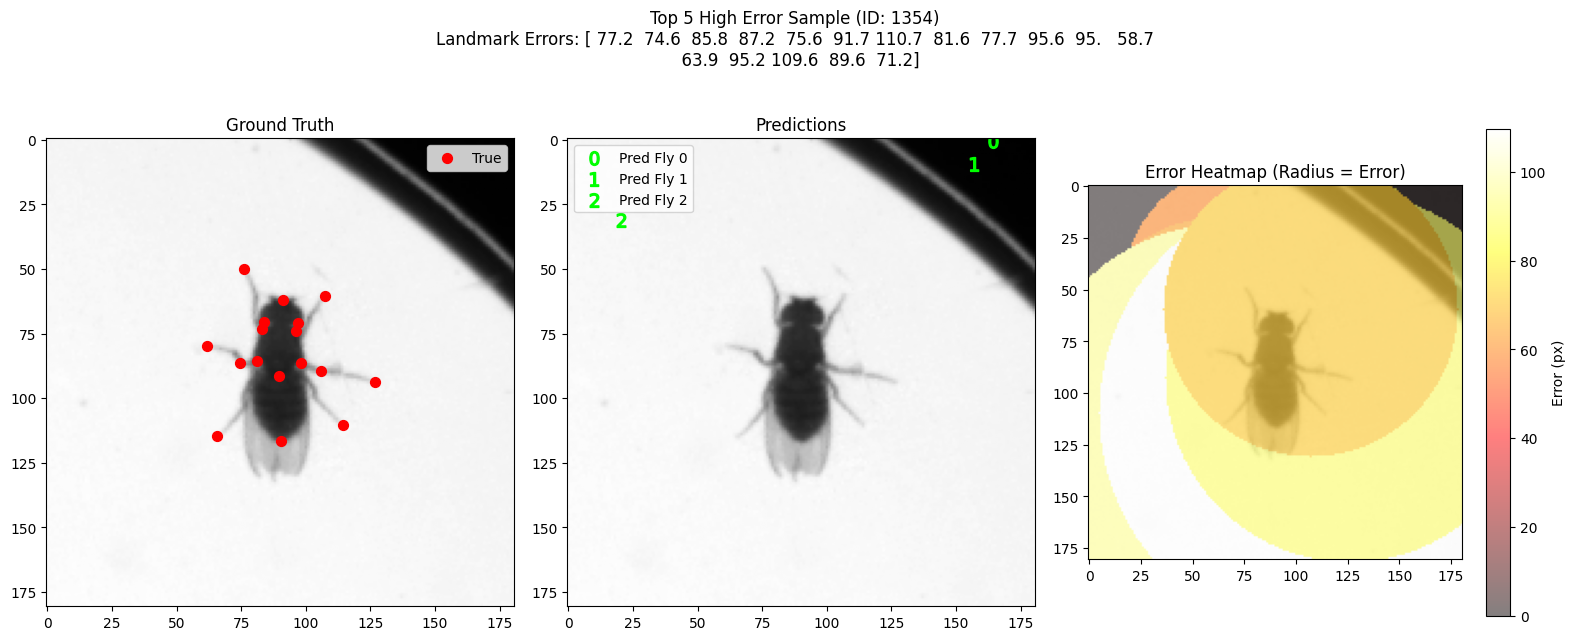

In [76]:
# ============== 原始大误差样本代码 (已注释) ==============
# idx = np.argsort(-np.sum(l2err_per_landmark_val, axis=1))
#
# for i in range(5):
#   d = train_dataset[val_ids[idx[i]]]
#   img = d['image'].unsqueeze(0)
#   net.eval()
#   with torch.no_grad():
#     pred = net.output(img.to(device))
#
#   fig=plt.figure(figsize=(12, 4), dpi=100)
#   with np.printoptions(precision=2):
#     errstr = str(l2err_per_landmark_val[idx[i]])
#   PlotLabelAndPrediction(d,pred[0, ...])  #,title_string='Err = %s '%errstr)

# ============== 新多苍蝇预测大误差样本版本 ==============
def visualize_high_error_samples(error_array, id_array, dataset, net,
                               top_n=5, confidence_thresh=0.3):
    """
    可视化误差最大的样本及其预测结果

    参数:
        error_array: 误差数组 (n_samples, n_landmarks)
        id_array: 对应的样本ID数组
        dataset: 数据集对象
        net: 训练好的网络
        top_n: 显示前N个高误差样本
        confidence_thresh: 预测置信度阈值
    """
    # 计算每个样本的总误差(忽略nan)
    summed_errors = np.nansum(error_array, axis=1)
    top_indices = np.argsort(-summed_errors)[:top_n]

    for i, sample_idx in enumerate(top_indices):
        sample_id = id_array[sample_idx]
        sample_errors = error_array[sample_idx]

        # 获取样本数据
        sample = dataset[sample_id]
        img_tensor = sample['image'].unsqueeze(0)
        true_locs = sample['landmarks']
        img_size = (img_tensor.shape[3], img_tensor.shape[2])  # (width, height)

        # 获取预测
        net.eval()
        with torch.no_grad():
            pred = net.output(img_tensor.to(device))[0]  # (max_flies, 3, h, w)

        # 检测苍蝇位置
        pred_flies = detect_multiple_flies(pred.cpu(), img_size, confidence_thresh)

        # 创建可视化
        fig = plt.figure(figsize=(16, 6), dpi=100)
        plt.suptitle(f"Top {i+1} High Error Sample (ID: {sample_id})\n"
                    f"Landmark Errors: {np.round(sample_errors, 1)}", y=1.05)

        # 原始图像和标注
        plt.subplot(1, 3, 1)
        img = COCODataset.get_image(sample)
        plt.imshow(img, cmap='gray')
        plt.scatter(true_locs[:, 0], true_locs[:, 1],
                   c='red', s=50, marker='o', label='True')
        plt.title("Ground Truth")
        plt.legend()

        # 预测结果
        plt.subplot(1, 3, 2)
        plt.imshow(img, cmap='gray')
        for fly_idx, (x, y) in enumerate(pred_flies):
            plt.scatter(x, y, c='lime', s=100,
                       marker=f'${fly_idx}$', label=f'Pred Fly {fly_idx}')
        plt.title("Predictions")
        plt.legend()

        # 误差热图
        plt.subplot(1, 3, 3)
        error_heatmap = np.zeros(img.shape[:2])
        for landmark_idx, err in enumerate(sample_errors):
            if not np.isnan(err):
                x, y = true_locs[landmark_idx]
                cv2.circle(error_heatmap, (int(x), int(y)),
                          radius=int(err),
                          color=err, thickness=-1)
        plt.imshow(img, cmap='gray', alpha=0.7)
        hm = plt.imshow(error_heatmap, cmap='hot', alpha=0.5)
        plt.colorbar(hm, label='Error (px)')
        plt.title("Error Heatmap (Radius = Error)")

        plt.tight_layout()
        plt.show()

# 使用示例
visualize_high_error_samples(
    l2err_per_landmark_val,
    val_ids,
    train_dataset,  # 注意这里使用train_dataset因为val是从train分割出来的
    net,
    top_n=5,
    confidence_thresh=0.3
)

# ============== 新增预测置信度分析 ==============
def analyze_prediction_confidence(pred):
    """分析预测置信度分布"""
    confidences = pred[:, 2].flatten().cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(confidences, bins=20, range=(0, 1))
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.title('Confidence Distribution')

    plt.subplot(1, 2, 2)
    plt.scatter(range(len(confidences)), sorted(confidences), s=5)
    plt.xlabel('Rank')
    plt.ylabel('Confidence')
    plt.title('Sorted Confidences')
    plt.tight_layout()
    plt.show()

    print(f"Confidence stats: Max={np.max(confidences):.2f}, "
          f"Mean={np.mean(confidences):.2f}, "
          f"Median={np.median(confidences):.2f}")

# 可以在visualize_high_error_samples中添加调用
# analyze_prediction_confidence(pred)

## Visulaization of layers

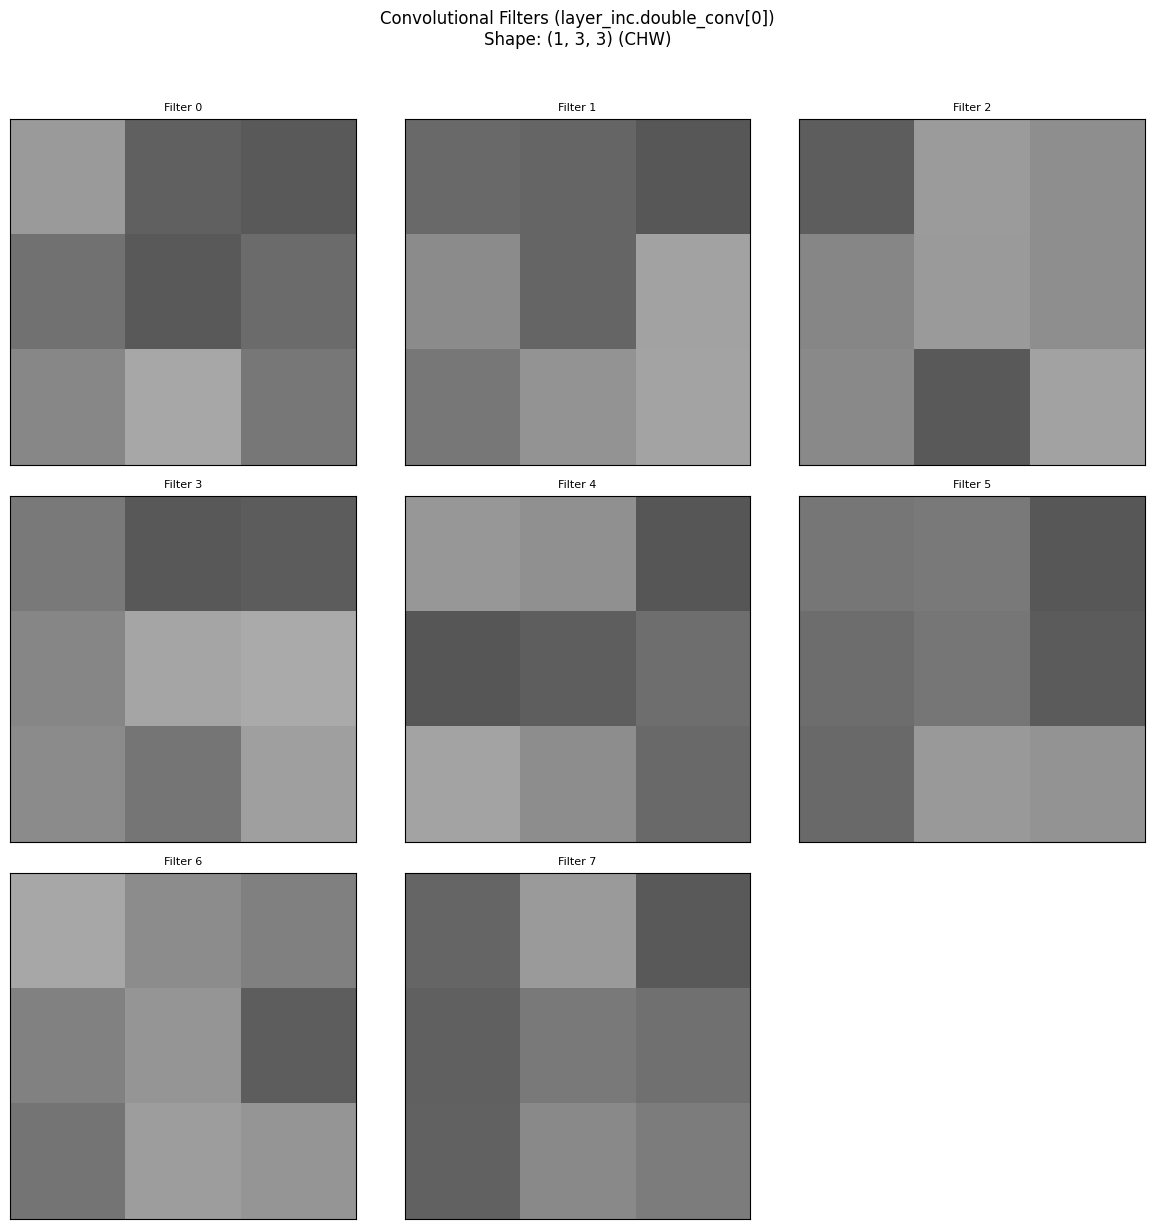

Filter statistics for layer_inc.double_conv[0]:
Min: -0.327, Max: 0.330
Mean: -0.022, Std: 0.203


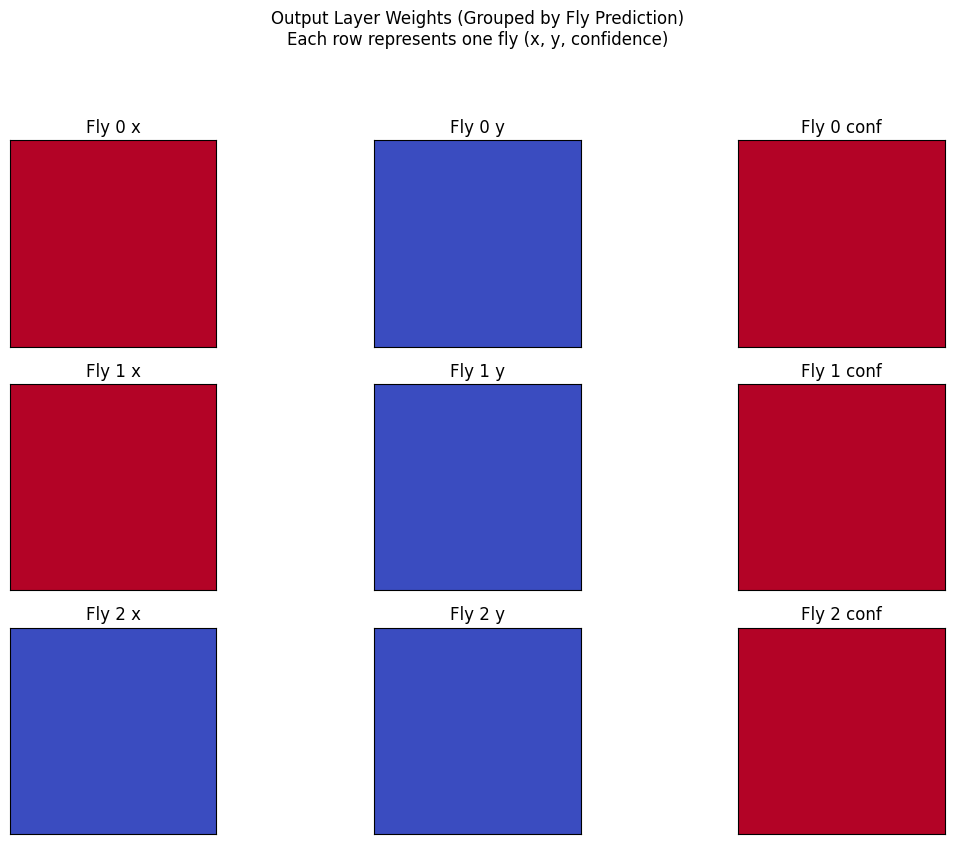

In [77]:
# ============== 原始卷积特征可视化代码 (已注释) ==============
# with torch.no_grad():
#   w = net.layer_inc.double_conv[0].weight.cpu().numpy()
# nr = int(np.ceil(np.sqrt(w.shape[0])))
# nc = int(np.ceil(w.shape[0] / nr))
# fig, ax = plt.subplots(nr, nc)
# for i in range(w.shape[0]):
#   r, c = np.unravel_index(i, (nr, nc))
#   fil = np.transpose(w[i, :, :, :], [1, 2, 0])
#   if fil.shape[-1] == 1:
#     fil = fil[:, :, 0]
#   ax[r][c].imshow(fil)
#   plt.axis('off')
# plt.tight_layout()
# plt.show()

# ============== 新多苍蝇预测卷积特征可视化版本 ==============
def visualize_conv_features(net, layer_path='layer_inc.double_conv[0]',
                          figsize=(12, 12), normalize=True):
    """
    可视化卷积层的滤波器

    参数:
        net: 神经网络模型
        layer_path: 要可视化的层路径(使用点表示法)
        figsize: 图像大小
        normalize: 是否归一化滤波器显示
    """
    # 获取指定层的权重
    layer = eval(f'net.{layer_path}')
    with torch.no_grad():
        weights = layer.weight.cpu().numpy()

    # 计算布局
    n_filters = weights.shape[0]
    in_channels = weights.shape[1]
    nr = int(np.ceil(np.sqrt(n_filters)))
    nc = int(np.ceil(n_filters / nr))

    # 创建图像
    fig, axes = plt.subplots(nr, nc, figsize=figsize)
    if nr == 1 and nc == 1:
        axes = np.array([[axes]])
    elif nr == 1 or nc == 1:
        axes = axes.reshape(nr, nc)

    # 可视化每个滤波器
    for i in range(n_filters):
        r, c = np.unravel_index(i, (nr, nc))
        ax = axes[r, c]

        # 获取当前滤波器(处理单通道和多通道情况)
        fil = weights[i]
        if in_channels == 1:  # 灰度输入
            fil = fil[0]  # (height, width)
            vmin, vmax = (-1, 1) if normalize else (fil.min(), fil.max())
            ax.imshow(fil, cmap='gray', vmin=vmin, vmax=vmax)
        else:  # 彩色输入
            fil = np.transpose(fil, (1, 2, 0))  # (height, width, channels)
            if normalize:
                fil = (fil - fil.min()) / (fil.max() - fil.min())
            ax.imshow(fil)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'Filter {i}', fontsize=8)

    # 隐藏多余的子图
    for i in range(n_filters, nr * nc):
        r, c = np.unravel_index(i, (nr, nc))
        axes[r, c].axis('off')

    plt.suptitle(f'Convolutional Filters ({layer_path})\n'
                f'Shape: {weights.shape[1:]} (CHW)', y=1.02)
    plt.tight_layout()
    plt.show()

    # 打印统计信息
    print(f"Filter statistics for {layer_path}:")
    print(f"Min: {weights.min():.3f}, Max: {weights.max():.3f}")
    print(f"Mean: {weights.mean():.3f}, Std: {weights.std():.3f}")

# 可视化第一层卷积特征
visualize_conv_features(net, layer_path='layer_inc.double_conv[0]')

# ============== 新增输出层可视化 ==============
def visualize_output_layer(net, layer_path='layer_outc.conv', figsize=(12, 8)):
    """可视化输出层的权重"""
    layer = eval(f'net.{layer_path}')
    with torch.no_grad():
        weights = layer.weight.cpu().numpy()  # (out_channels, in_channels, h, w)

    # 输出层特殊处理(多苍蝇预测)
    max_flies = net.max_flies
    out_channels = weights.shape[0]

    # 检查形状是否符合预期
    if out_channels != max_flies * 3:
        print(f"Warning: Unexpected output channels. Expected {max_flies*3}, got {out_channels}")

    # 创建可视化
    fig, axes = plt.subplots(max_flies, 3, figsize=figsize)
    plt.suptitle(f'Output Layer Weights (Grouped by Fly Prediction)\n'
                f'Each row represents one fly (x, y, confidence)', y=1.05)

    for fly in range(max_flies):
        for j, pred_type in enumerate(['x', 'y', 'conf']):
            ax = axes[fly, j]
            channel = fly * 3 + j
            if channel < weights.shape[0]:
                # 取所有输入通道的平均权重
                filter_weights = weights[channel].mean(axis=0)
                vmax = max(abs(filter_weights.max()), abs(filter_weights.min()))
                ax.imshow(filter_weights, cmap='coolwarm', vmin=-vmax, vmax=vmax)
                ax.set_title(f'Fly {fly} {pred_type}')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# 可视化输出层权重
visualize_output_layer(net)

## Final evaluation on the test set

In [ ]:
# final evaluation on the test set. for proper evaluation, and to avoid overfitting
# to the test set, we want to change parameters based on the validation set, and
# only at the very end evaluate on the test set

with open(testannfile) as f:
  testann = json.load(f)
f.close()
ntestims = len(testann['images'])
# Make sure we have all the images
t = glob(os.path.join(testdir, '*.png'))
print(f"N. test images = {ntestims}, number of images unzipped = {len(t)}")
assert ntestims==len(t), 'number of annotations and number of images do not match'

test_dataset = COCODataset(testannfile, datadir=testdir, landmarks=landmarks)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=2,
                                              shuffle=True)

l2err_per_landmark_test, test_ids = eval_net(net, test_dataloader)

N. test images = 1800, number of images unzipped = 1800


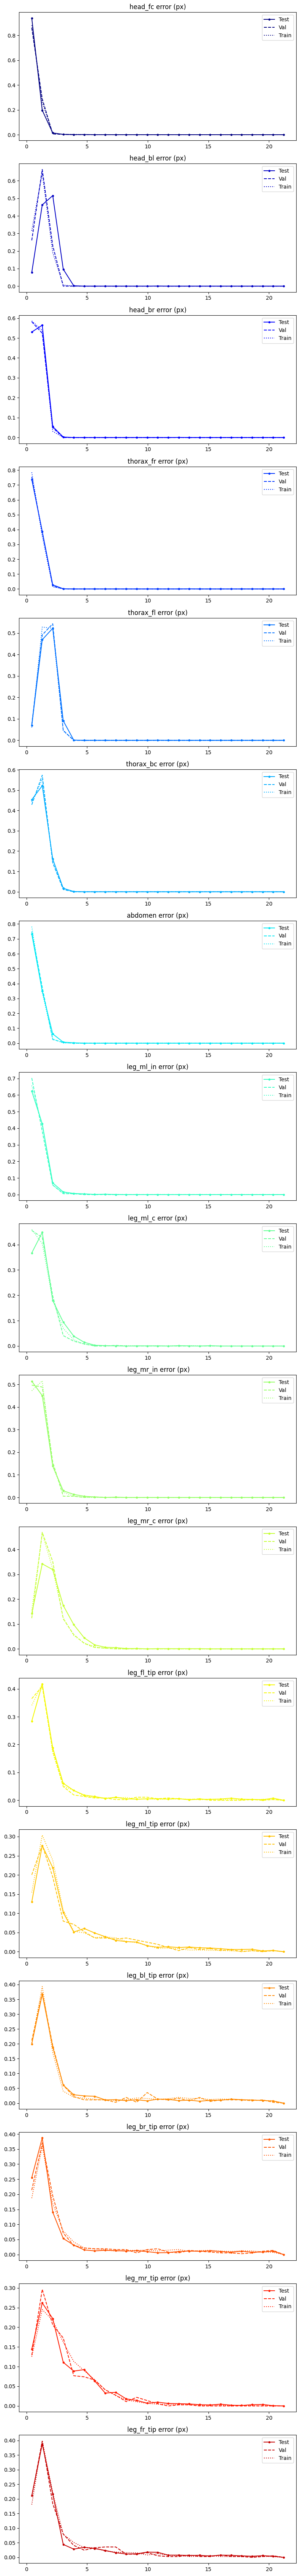

In [ ]:
# Plot the error distribution
nbins = 25
bin_edges = np.linspace(0, np.percentile(l2err_per_landmark_val, 99.),
                        nbins + 1)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.
bin_edges[-1] = np.inf
frac_val = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_train = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
frac_test = np.zeros((nbins, l2err_per_landmark_val.shape[1]))
for i in range(l2err_per_landmark_val.shape[1]):
  frac_val[:, i], _ = np.histogram(l2err_per_landmark_val[:, i],
                                   bin_edges, density=True)
  frac_train[:, i], _ = np.histogram(l2err_per_landmark_train[:, i],
                                     bin_edges, density=True)
  frac_test[:, i], _ = np.histogram(l2err_per_landmark_test[:, i],
                                    bin_edges, density=True)

fig=plt.figure(figsize=(8, 4 * train_dataset.nlandmarks), dpi=100)
for i in range(train_dataset.nlandmarks):
  if landmarks is None:
    landmark_name = landmark_names[i]
  else:
    landmark_name = landmark_names[landmarks[i]]
  plt.subplot(train_dataset.nlandmarks, 1, i + 1)
  plt.plot(bin_centers, frac_test[:, i], '.-',
           label='Test', color=colors[i, :])
  plt.plot(bin_centers, frac_val[:, i], '--',
           label='Val', color=colors[i, :])
  plt.plot(bin_centers, frac_train[:, i], ':',
           label='Train', color=colors[i, :])
  plt.legend()
  plt.title(f"{landmark_name} error (px)")
plt.tight_layout()
plt.show()

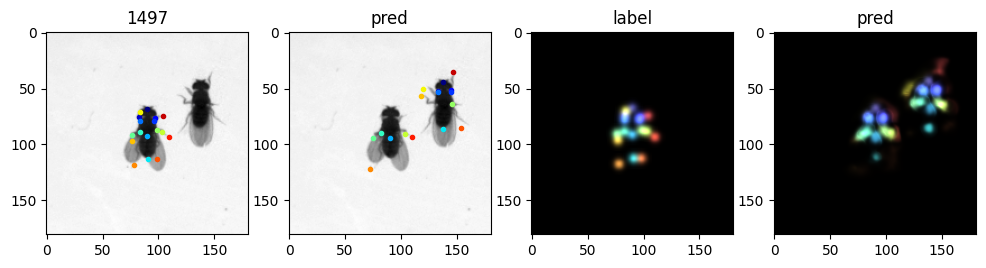

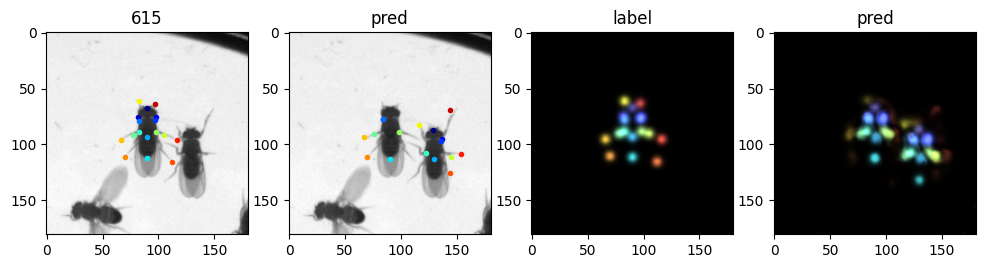

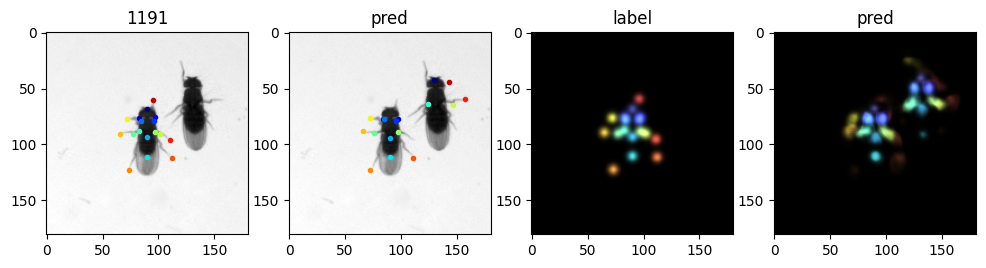

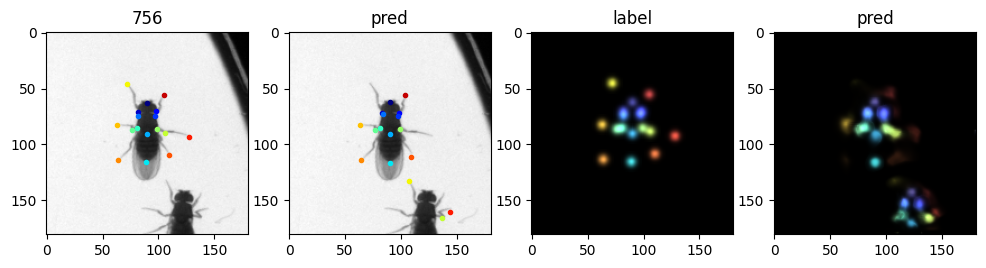

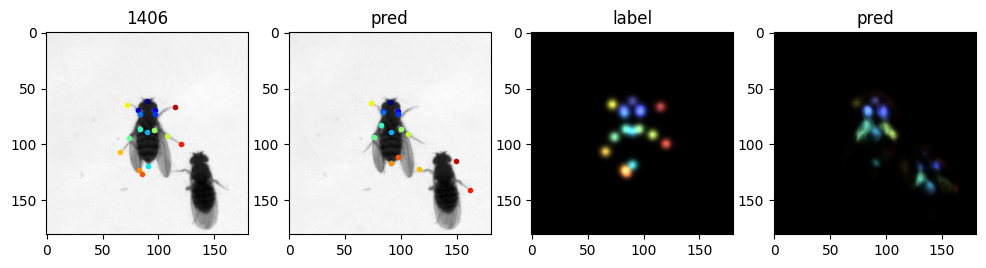

In [ ]:
# Plot examples with big errors
idx = np.argsort(-np.sum(l2err_per_landmark_test, axis=1))

for i in range(5):
  d = test_dataset[test_ids[idx[i]]]
  img = d['image'].unsqueeze(0)
  net.eval()
  with torch.no_grad():
    pred = net.output(img.to(device))

  fig=plt.figure(figsize=(12, 4), dpi=100)
  with np.printoptions(precision=2):
    errstr = str(l2err_per_landmark_test[idx[i]])
  PlotLabelAndPrediction(d, pred[0, ...])  #,title_string='Err = %s '%errstr)